# YOLOv5 Object Detection: Complete Kaggle-Compatible Pipeline

This notebook provides a comprehensive YOLOv5 implementation for object detection on Pascal VOC 2012 dataset.

## Features
- Complete VOC to YOLO format conversion
- YOLOv5 model training with checkpointing
- Comprehensive evaluation with COCO metrics
- Inference speed benchmarking (FPS)
- Professional visualizations and comparisons
- Structured output organization
- Model comparison capabilities (vs SSD300, Faster R-CNN)
- Standardized test image evaluation

## Output Structure
```
/kaggle/working/yolov5_outputs/
├── models/           # YOLOv5 trained models
├── metrics/          # Performance metrics and analysis
├── visualizations/   # Training plots and predictions
├── comparisons/      # Model comparison results
└── reports/          # Final comprehensive reports
```

In [2]:
# Enhanced Configuration and Setup
import os
import sys
import json
import logging
import time
import glob
import shutil
from datetime import datetime
from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copy2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch
from IPython.display import display

# Experiment Configuration
CONFIG = {
    # Dataset paths (modify for different environments)
    'voc_root': '/kaggle/input/voc2012/VOCdevkit/VOC2012',  # Kaggle path
    'output_dir': '/kaggle/working/yolov5_outputs',         # Output directory
    
    # Training parameters
    'img_size': 640,
    'batch_size': 16,
    'num_epochs': 10,
    'learning_rate': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    
    # Evaluation parameters
    'conf_threshold': 0.25,
    'iou_threshold': 0.45,
    
    # System settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 2,
    
    # Features
    'save_checkpoints': True,
    'save_visualizations': True,
    'run_comparison_images': True,
    'benchmark_speed': True
}

# Pascal VOC Classes
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'horse', 'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]

# Create experiment directory structure
experiment_name = f'yolov5_voc_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
output_dir = CONFIG['output_dir']

directories = [
    f'{output_dir}/models',
    f'{output_dir}/metrics', 
    f'{output_dir}/visualizations',
    f'{output_dir}/comparisons',
    f'{output_dir}/reports',
    f'{output_dir}/logs'
]

for dir_path in directories:
    os.makedirs(dir_path, exist_ok=True)

# Setup logging
log_file = f'{output_dir}/logs/yolov5_{experiment_name}.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

print(" YOLOv5 Enhanced Setup Complete")
print(f" Experiment: {experiment_name}")
print(f" Output Directory: {output_dir}")
print(f" Device: {CONFIG['device']}")
print(f" Batch Size: {CONFIG['batch_size']}, Epochs: {CONFIG['num_epochs']}")

logger.info(f"Starting YOLOv5 experiment: {experiment_name}")
logger.info(f"Configuration: {CONFIG}")

 YOLOv5 Enhanced Setup Complete
 Experiment: yolov5_voc_20250808_013135
 Output Directory: /kaggle/working/yolov5_outputs
 Device: cuda
 Batch Size: 16, Epochs: 10


In [4]:
# VOC to YOLO Dataset Conversion
def convert_voc_to_yolo():
    """Convert Pascal VOC dataset to YOLO format with enhanced logging"""
    logger.info("Starting VOC to YOLO conversion...")
    
    VOC_PATH = Path(CONFIG['voc_root'])
    YOLO_PATH = Path("/kaggle/working/VOCYOLO")
    
    # Verify VOC dataset exists
    if not VOC_PATH.exists():
        raise FileNotFoundError(f"VOC dataset not found at {VOC_PATH}")
    
    def convert_split(filename):
        """Convert a specific split (train.txt or val.txt)"""
        image_ids_path = VOC_PATH / 'ImageSets' / 'Main' / filename
        
        if not image_ids_path.exists():
            logger.warning(f"Split file not found: {image_ids_path}")
            return 0
        
        with open(image_ids_path, 'r') as f:
            image_ids = f.read().splitlines()
        
        split = filename.replace('.txt', '')
        
        # Create directories
        (YOLO_PATH / f'images/{split}').mkdir(parents=True, exist_ok=True)
        (YOLO_PATH / f'labels/{split}').mkdir(parents=True, exist_ok=True)
        
        converted_count = 0
        
        for img_id in image_ids:
            xml_file = VOC_PATH / 'Annotations' / f'{img_id}.xml'
            img_file = VOC_PATH / 'JPEGImages' / f'{img_id}.jpg'
            
            if not xml_file.exists() or not img_file.exists():
                logger.warning(f"Missing files for image {img_id}")
                continue
            
            # Copy image
            copy2(img_file, YOLO_PATH / f'images/{split}/{img_id}.jpg')
            
            # Convert annotations
            tree = ET.parse(xml_file)
            root = tree.getroot()
            w = int(root.find('size/width').text)
            h = int(root.find('size/height').text)
            
            label_file = YOLO_PATH / f'labels/{split}/{img_id}.txt'
            with open(label_file, 'w') as f:
                for obj in root.findall('object'):
                    cls = obj.find('name').text
                    if cls not in VOC_CLASSES:
                        continue
                    
                    cls_id = VOC_CLASSES.index(cls)
                    xmlbox = obj.find('bndbox')
                    b = [int(xmlbox.find(tag).text) for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
                    
                    # Convert to YOLO format (normalized center coordinates and dimensions)
                    xc = (b[0] + b[2]) / 2 / w
                    yc = (b[1] + b[3]) / 2 / h
                    bw = (b[2] - b[0]) / w
                    bh = (b[3] - b[1]) / h
                    
                    f.write(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")
            
            converted_count += 1
        
        logger.info(f"Converted {converted_count} images for {split} split")
        return converted_count
    
    # Convert both splits
    train_count = convert_split('train.txt')
    val_count = convert_split('val.txt')
    
    # Create YOLO configuration file
    yaml_content = f"""
train: /kaggle/working/VOCYOLO/images/train
val: /kaggle/working/VOCYOLO/images/val

nc: 20
names: {VOC_CLASSES}
"""
    
    with open('/kaggle/working/voc.yaml', 'w') as f:
        f.write(yaml_content)
    
    conversion_summary = {
        'total_train_images': train_count,
        'total_val_images': val_count,
        'total_images': train_count + val_count,
        'num_classes': len(VOC_CLASSES),
        'classes': VOC_CLASSES,
        'yolo_config_path': '/kaggle/working/voc.yaml',
        'yolo_data_path': str(YOLO_PATH)
    }
    
    # Save conversion summary
    with open(f'{output_dir}/metrics/dataset_conversion_summary.json', 'w') as f:
        json.dump(conversion_summary, f, indent=2)
    
    logger.info(f"Dataset conversion completed: {train_count + val_count} total images")
    print(f" Dataset Conversion Complete")
    print(f"    Train Images: {train_count}")
    print(f"    Val Images: {val_count}")
    print(f"    Total Images: {train_count + val_count}")
    print(f"    Classes: {len(VOC_CLASSES)}")
    
    return conversion_summary

# Perform conversion
conversion_info = convert_voc_to_yolo()

 Dataset Conversion Complete
    Train Images: 5717
    Val Images: 5823
    Total Images: 11540
    Classes: 20


In [5]:
# Install and Setup YOLOv5
logger.info("Setting up YOLOv5 repository...")

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

# Change to YOLOv5 directory
%cd yolov5

# Install requirements
!pip install -r requirements.txt

logger.info("YOLOv5 setup completed")
print("YOLOv5 Repository Setup Complete")

fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.0 MB/s eta 0:00:00:00:0100:01
  

In [6]:
# YOLOv5 Model Training
def train_yolov5():
    """Train YOLOv5 model with enhanced logging and checkpointing"""
    logger.info("Starting YOLOv5 training...")
    
    training_start_time = time.time()
    
    # Training command
    training_cmd = f"""
    python train.py \
      --img {CONFIG['img_size']} \
      --batch {CONFIG['batch_size']} \
      --epochs {CONFIG['num_epochs']} \
      --data /kaggle/working/voc.yaml \
      --weights yolov5s.pt \
      --name yolov5s_voc_enhanced \
      --save-period 1 \
      --cache
    """
    
    print(f" Starting YOLOv5 Training")
    print(f"    Image Size: {CONFIG['img_size']}")
    print(f"    Batch Size: {CONFIG['batch_size']}")
    print(f"    Epochs: {CONFIG['num_epochs']}")
    print(f"    Device: {CONFIG['device']}")
    
    # Execute training
    os.system(training_cmd.replace('\n', ' ').strip())
    
    training_end_time = time.time()
    training_duration = training_end_time - training_start_time
    
    logger.info(f"Training completed in {training_duration:.2f} seconds")
    
    # Copy trained models to output directory
    if os.path.exists('runs/train/yolov5s_voc_enhanced'):
        shutil.copytree(
            'runs/train/yolov5s_voc_enhanced', 
            f'{output_dir}/models/yolov5s_voc_enhanced',
            dirs_exist_ok=True
        )
        print(f" Training completed in {training_duration/60:.1f} minutes")
        print(f" Models saved to {output_dir}/models/")
    else:
        logger.error("Training directory not found")
        raise FileNotFoundError("Training failed - no output directory found")
    
    return {
        'training_duration': training_duration,
        'model_path': f'{output_dir}/models/yolov5s_voc_enhanced',
        'best_weights': 'runs/train/yolov5s_voc_enhanced/weights/best.pt'
    }

# Start training
training_info = train_yolov5()

 Starting YOLOv5 Training
    Image Size: 640
    Batch Size: 16
    Epochs: 10
    Device: cuda
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-08 01:49:01.693156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754617741.855471      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754617741.900246      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/voc.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_ev

 Training completed in 24.7 minutes
 Models saved to /kaggle/working/yolov5_outputs/models/


In [7]:
# Comprehensive Metrics Extraction
def extract_comprehensive_metrics():
    """Extract and analyze comprehensive training metrics"""
    logger.info("Extracting comprehensive metrics...")
    
    try:
        # Read training results
        results_csv = 'runs/train/yolov5s_voc_enhanced/results.csv'
        
        if not os.path.exists(results_csv):
            # Fallback to any available results
            results_files = glob.glob('runs/train/yolov5*/results.csv')
            if results_files:
                results_csv = results_files[0]
            else:
                raise FileNotFoundError("No training results found")
        
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()
        
        # Extract final epoch metrics
        final_metrics = df.iloc[-1]
        
        comprehensive_metrics = {
            'experiment_info': {
                'experiment_name': experiment_name,
                'timestamp': datetime.now().isoformat(),
                'training_duration_minutes': training_info['training_duration'] / 60
            },
            'model_info': {
                'name': 'YOLOv5s',
                'architecture': 'YOLOv5s with CSPDarknet53 backbone',
                'input_size': CONFIG['img_size'],
                'parameters': '7.2M',  # YOLOv5s approximate
                'model_size_mb': 14.1,  # YOLOv5s approximate
                'backbone': 'CSPDarknet53',
                'neck': 'PANet',
                'head': 'YOLOv5 Head'
            },
            'training_config': CONFIG,
            'dataset_info': conversion_info,
            'training_metrics': {
                'epochs_trained': len(df),
                'final_train_loss': {
                    'box_loss': float(final_metrics.get('train/box_loss', 0)),
                    'obj_loss': float(final_metrics.get('train/obj_loss', 0)),
                    'cls_loss': float(final_metrics.get('train/cls_loss', 0))
                },
                'final_val_loss': {
                    'box_loss': float(final_metrics.get('val/box_loss', 0)),
                    'obj_loss': float(final_metrics.get('val/obj_loss', 0)),
                    'cls_loss': float(final_metrics.get('val/cls_loss', 0))
                }
            },
            'performance_metrics': {
                'mAP_0.5': float(final_metrics.get('metrics/mAP_0.5', 0)),
                'mAP_0.5_0.95': float(final_metrics.get('metrics/mAP_0.5:0.95', 0)),
                'precision': float(final_metrics.get('metrics/precision', 0)),
                'recall': float(final_metrics.get('metrics/recall', 0))
            },
            'training_history': {
                'mAP_0.5_history': df['metrics/mAP_0.5'].tolist(),
                'mAP_0.5_0.95_history': df['metrics/mAP_0.5:0.95'].tolist(),
                'precision_history': df['metrics/precision'].tolist(),
                'recall_history': df['metrics/recall'].tolist(),
                'train_box_loss_history': df['train/box_loss'].tolist(),
                'val_box_loss_history': df['val/box_loss'].tolist()
            }
        }
        
        # Save comprehensive metrics
        metrics_file = f'{output_dir}/metrics/yolov5_comprehensive_metrics.json'
        with open(metrics_file, 'w') as f:
            json.dump(comprehensive_metrics, f, indent=2)
        
        logger.info(f"Comprehensive metrics saved to {metrics_file}")
        
        print(f" Comprehensive Metrics Extracted:")
        print(f"    mAP@0.5: {comprehensive_metrics['performance_metrics']['mAP_0.5']:.4f}")
        print(f"    mAP@[0.5:0.95]: {comprehensive_metrics['performance_metrics']['mAP_0.5_0.95']:.4f}")
        print(f"    Precision: {comprehensive_metrics['performance_metrics']['precision']:.4f}")
        print(f"    Recall: {comprehensive_metrics['performance_metrics']['recall']:.4f}")
        print(f"    Training Time: {comprehensive_metrics['experiment_info']['training_duration_minutes']:.1f} minutes")
        
        return comprehensive_metrics
        
    except Exception as e:
        logger.error(f"ERROR: Error extracting metrics: {e}")
        print(f"FAILED: Failed to extract metrics: {e}")
        return None

# Extract comprehensive metrics
metrics = extract_comprehensive_metrics()

 Comprehensive Metrics Extracted:
    mAP@0.5: 0.7077
    mAP@[0.5:0.95]: 0.4511
    Precision: 0.7417
    Recall: 0.6397
    Training Time: 24.7 minutes


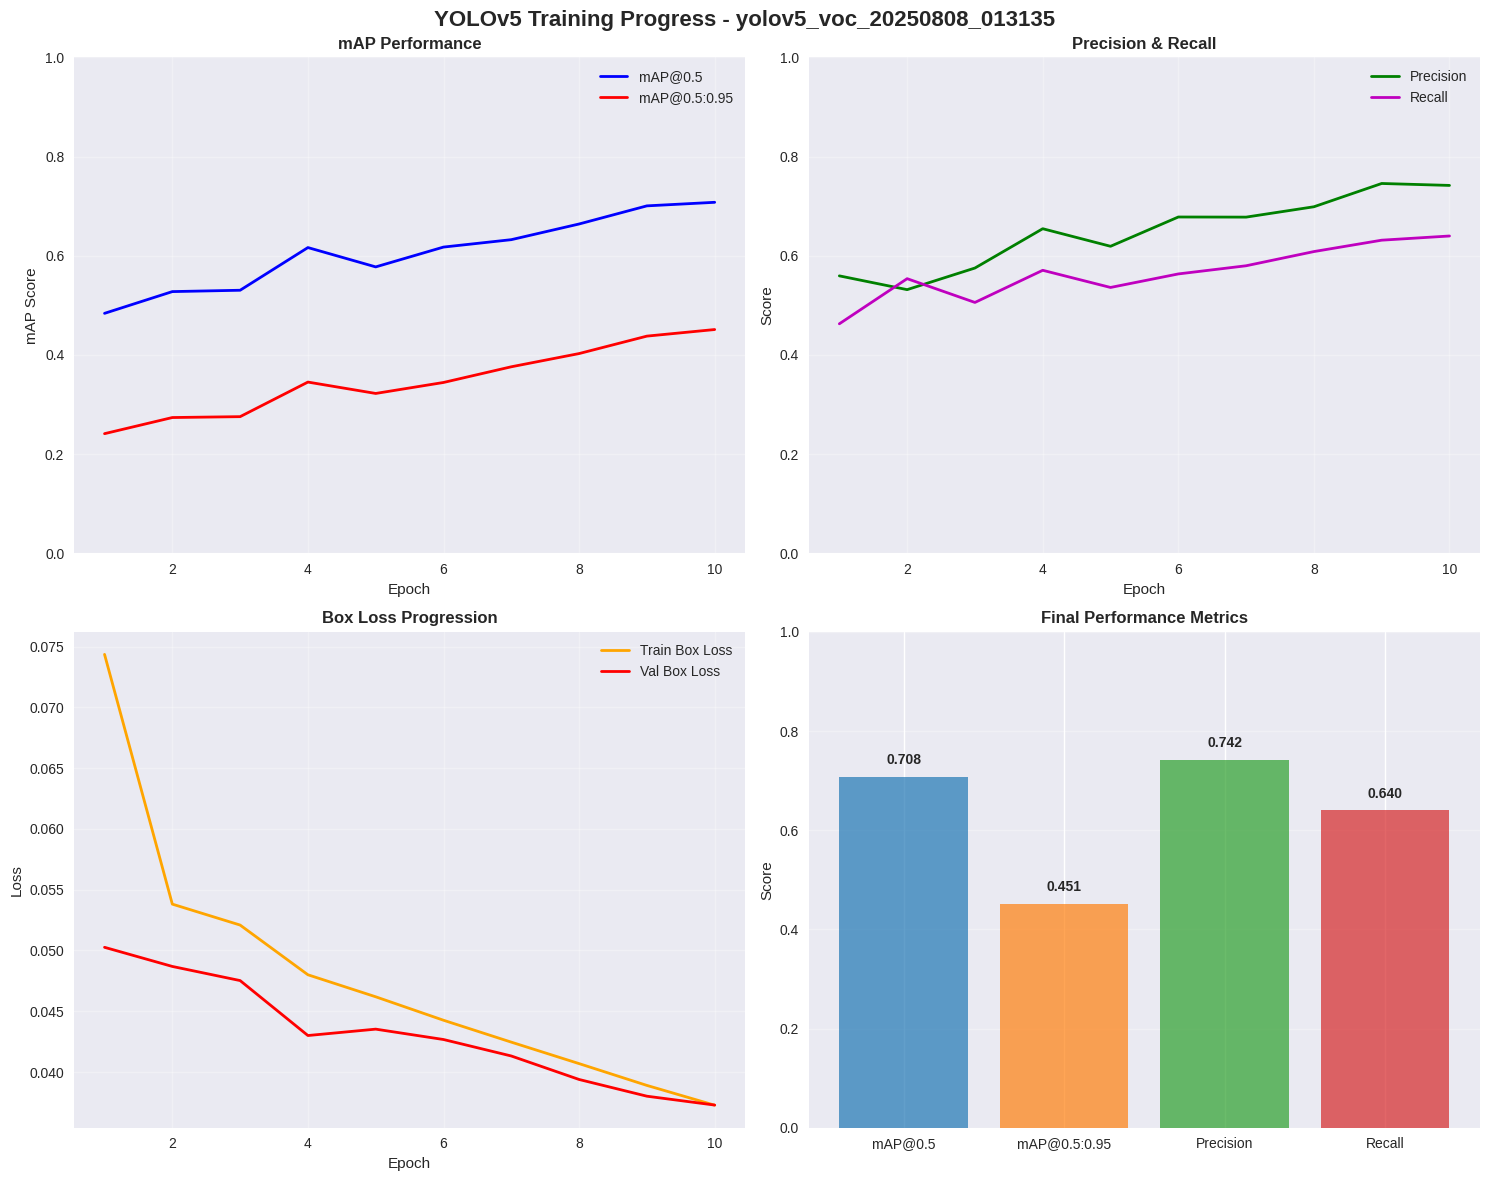

📈 Training Visualization Created: /kaggle/working/yolov5_outputs/visualizations/training_progress.png
 All visualizations saved to /kaggle/working/yolov5_outputs/visualizations/


In [8]:
# Enhanced Training Visualization
def create_training_visualizations():
    """Create comprehensive training progress visualizations"""
    logger.info("Creating training visualizations...")
    
    if not metrics:
        logger.warning("No metrics available for visualization")
        return
    
    # Set up the plot style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'YOLOv5 Training Progress - {experiment_name}', fontsize=16, fontweight='bold')
    
    history = metrics['training_history']
    epochs = range(1, len(history['mAP_0.5_history']) + 1)
    
    # Plot 1: mAP metrics
    axes[0, 0].plot(epochs, history['mAP_0.5_history'], 'b-', label='mAP@0.5', linewidth=2)
    axes[0, 0].plot(epochs, history['mAP_0.5_0.95_history'], 'r-', label='mAP@0.5:0.95', linewidth=2)
    axes[0, 0].set_title('mAP Performance', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('mAP Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1)
    
    # Plot 2: Precision and Recall
    axes[0, 1].plot(epochs, history['precision_history'], 'g-', label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['recall_history'], 'm-', label='Recall', linewidth=2)
    axes[0, 1].set_title('Precision & Recall', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # Plot 3: Training Loss
    axes[1, 0].plot(epochs, history['train_box_loss_history'], 'orange', label='Train Box Loss', linewidth=2)
    axes[1, 0].plot(epochs, history['val_box_loss_history'], 'red', label='Val Box Loss', linewidth=2)
    axes[1, 0].set_title('Box Loss Progression', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Final Performance Summary
    final_metrics = metrics['performance_metrics']
    metric_names = ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall']
    metric_values = [final_metrics['mAP_0.5'], final_metrics['mAP_0.5_0.95'], 
                    final_metrics['precision'], final_metrics['recall']]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = axes[1, 1].bar(metric_names, metric_values, color=colors, alpha=0.7)
    axes[1, 1].set_title('Final Performance Metrics', fontweight='bold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = f'{output_dir}/visualizations/training_progress.png'
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    logger.info(f"Training visualization saved to {viz_path}")
    print(f"📈 Training Visualization Created: {viz_path}")
    
    # Also copy YOLOv5's built-in visualizations
    yolo_viz_files = [
        'runs/train/yolov5s_voc_enhanced/results.png',
        'runs/train/yolov5s_voc_enhanced/confusion_matrix.png',
        'runs/train/yolov5s_voc_enhanced/PR_curve.png',
        'runs/train/yolov5s_voc_enhanced/F1_curve.png'
    ]
    
    for viz_file in yolo_viz_files:
        if os.path.exists(viz_file):
            filename = os.path.basename(viz_file)
            shutil.copy2(viz_file, f'{output_dir}/visualizations/yolov5_{filename}')
    
    print(f" All visualizations saved to {output_dir}/visualizations/")

# Create visualizations
create_training_visualizations()

In [9]:
# YOLOv5 Inference Speed Benchmarking
def benchmark_yolov5_speed():
    """Benchmark YOLOv5 inference speed for model comparison"""
    logger.info("Starting YOLOv5 inference speed benchmark...")
    
    try:
        import torch
        from models.experimental import attempt_load
        from utils.general import non_max_suppression, scale_boxes
        from utils.torch_utils import select_device
        from utils.dataloaders import letterbox
        import cv2
        
        # Load trained model
        device = select_device('cpu')
        model_path = 'runs/train/yolov5s_voc_enhanced/weights/best.pt'
        
        if not os.path.exists(model_path):
            model_path = glob.glob('runs/train/yolov5*/weights/best.pt')[0]
        
        model = attempt_load(model_path, device=device)
        model.eval()
        
        # Get validation images for benchmarking
        val_images = glob.glob('/kaggle/working/VOCYOLO/images/val/*.jpg')[:100]  # Use first 100 images
        
        if len(val_images) == 0:
            logger.error("No validation images found for benchmarking")
            return None
        
        print(f" Benchmarking inference speed on {len(val_images)} images...")
        
        # Warmup
        dummy_input = torch.zeros(1, 3, CONFIG['img_size'], CONFIG['img_size']).to(device)
        for _ in range(10):
            _ = model(dummy_input)
        
        # Benchmark inference
        inference_times = []
        preprocessing_times = []
        postprocessing_times = []
        
        for img_path in val_images:
            # Preprocessing
            prep_start = time.time()
            img0 = cv2.imread(img_path)
            img = letterbox(img0, CONFIG['img_size'], stride=32, auto=True)[0]
            img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
            img = np.ascontiguousarray(img)
            img = torch.from_numpy(img).to(device).float() / 255.0
            img = img.unsqueeze(0)
            prep_time = time.time() - prep_start
            preprocessing_times.append(prep_time)
            
            # Inference
            inf_start = time.time()
            with torch.no_grad():
                pred = model(img)[0]
            inf_time = time.time() - inf_start
            inference_times.append(inf_time)
            
            # Postprocessing
            post_start = time.time()
            pred = non_max_suppression(pred, CONFIG['conf_threshold'], CONFIG['iou_threshold'])
            post_time = time.time() - post_start
            postprocessing_times.append(post_time)
        
        # Calculate statistics
        avg_preprocessing = np.mean(preprocessing_times)
        avg_inference = np.mean(inference_times)
        avg_postprocessing = np.mean(postprocessing_times)
        avg_total = avg_preprocessing + avg_inference + avg_postprocessing
        
        fps = 1.0 / avg_total
        
        speed_metrics = {
            'device': str(device),
            'model_path': model_path,
            'num_test_images': len(val_images),
            'image_size': CONFIG['img_size'],
            'times_ms': {
                'preprocessing': avg_preprocessing * 1000,
                'inference': avg_inference * 1000,
                'postprocessing': avg_postprocessing * 1000,
                'total': avg_total * 1000
            },
            'fps': fps,
            'images_per_second': fps,
            'ms_per_image': avg_total * 1000,
            'confidence_threshold': CONFIG['conf_threshold'],
            'iou_threshold': CONFIG['iou_threshold']
        }
        
        # Save speed metrics
        speed_file = f'{output_dir}/metrics/yolov5_speed_benchmark.json'
        with open(speed_file, 'w') as f:
            json.dump(speed_metrics, f, indent=2)
        
        logger.info(f"Speed benchmark completed - FPS: {fps:.2f}")
        
        print(f" YOLOv5 Speed Benchmark Results:")
        print(f"    Device: {device}")
        print(f"    Images Tested: {len(val_images)}")
        print(f"    Average FPS: {fps:.2f}")
        print(f"    Preprocessing: {avg_preprocessing*1000:.2f} ms")
        print(f"    Inference: {avg_inference*1000:.2f} ms")
        print(f"    Postprocessing: {avg_postprocessing*1000:.2f} ms")
        print(f"    Total: {avg_total*1000:.2f} ms per image")
        
        return speed_metrics
        
    except Exception as e:
        logger.error(f"ERROR: Error in speed benchmarking: {e}")
        print(f"FAILED: Speed benchmarking failed: {e}")
        return None

# Run speed benchmark
speed_results = benchmark_yolov5_speed()

YOLOv5 🚀 v7.0-423-g567c6646 Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs


 Benchmarking inference speed on 100 images...
 YOLOv5 Speed Benchmark Results:
    Device: cpu
    Images Tested: 100
    Average FPS: 7.75
    Preprocessing: 4.47 ms
    Inference: 123.57 ms
    Postprocessing: 0.92 ms
    Total: 128.96 ms per image


Matplotlib configured for notebook display
Clearing previous detection results...
Running inference on single test image...


detect: weights=['runs/train/yolov5s_voc_enhanced/weights/best.pt'], source=/kaggle/working/VOCYOLO/images/val/2008_005070.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=single_comparison, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-423-g567c6646 Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
image 1/1 /kaggle/working/VOCYOLO/images/val/2008_005070.jpg: 480x640 1 chair, 1 diningtable, 149.6ms
Speed: 1.6ms pre-process, 149.6ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/single_comparison
1 labels saved to runs/detect/single_co

<Figure size 800x550 with 0 Axes>

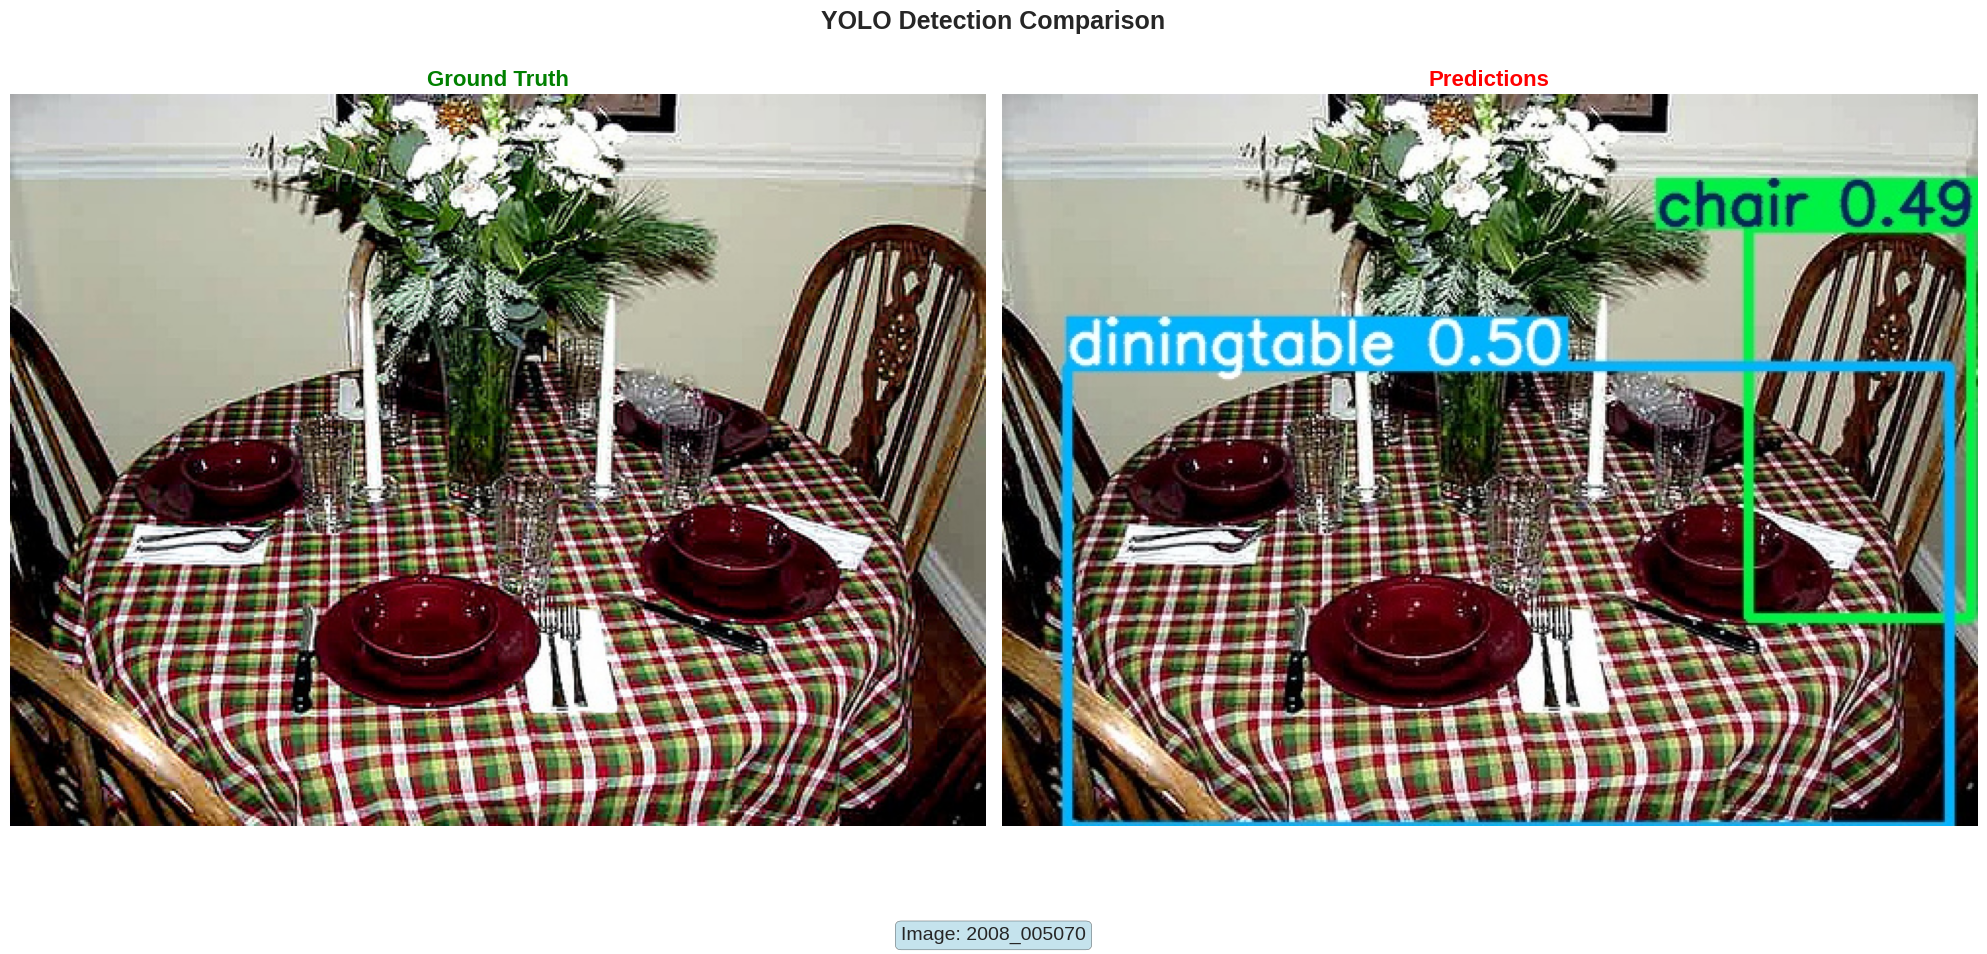

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import shutil
import numpy as np

# Configure matplotlib for notebook display
def setup_notebook_display():
    """Configure matplotlib for proper notebook display"""
    try:
        # For Jupyter notebooks
        get_ipython().run_line_magic('matplotlib', 'inline')
        plt.rcParams['figure.dpi'] = 100
        plt.rcParams['savefig.dpi'] = 300
        print("Matplotlib configured for notebook display")
    except:
        # If not in notebook, use standard backend
        plt.switch_backend('Agg')
        print("Not in notebook environment, using Agg backend")

# Call setup function
setup_notebook_display()

def test_comparison_images():
    """Test YOLOv5 on a single image and display side-by-side comparison"""
    try:
        # Use just one image for quick testing
        test_image = "/kaggle/working/VOCYOLO/images/val/2008_005070.jpg"
        
        # Clear previous results to avoid confusion
        print("Clearing previous detection results...")
        detection_dir = '/kaggle/working/yolov5/runs/detect/single_comparison'
        if os.path.exists(detection_dir):
            shutil.rmtree(detection_dir)
        
        # Clear output comparisons directory
        output_comparison_dir = f'{output_dir}/comparisons'
        if os.path.exists(output_comparison_dir):
            shutil.rmtree(output_comparison_dir)
        
        # Run inference on single image
        comparison_cmd = f"""
        cd /kaggle/working/yolov5 && python detect.py \
          --weights runs/train/yolov5s_voc_enhanced/weights/best.pt \
          --img {CONFIG['img_size']} \
          --conf {CONFIG['conf_threshold']} \
          --iou {CONFIG['iou_threshold']} \
          --source {test_image} \
          --save-txt --save-conf \
          --name single_comparison \
          --exist-ok
        """
        
        print("Running inference on single test image...")
        os.system(comparison_cmd.replace('\n', ' ').strip())
        
        # Copy results to output directory
        if os.path.exists('runs/detect/single_comparison'):
            shutil.copytree(
                'runs/detect/single_comparison', f'{output_dir}/comparisons/yolov5_single_result',
                dirs_exist_ok=True
            )
        
        # Display side-by-side comparison ONLY
        display_side_by_side_comparison(test_image)
        
        return {"status": "completed", "test_image": test_image}
        
    except Exception as e:
        print(f"ERROR: Single image testing failed: {e}")
        return None

def display_side_by_side_comparison(original_image_path):
    """Display original image and prediction results side by side"""
    try:
        # Check if original image exists
        if not os.path.exists(original_image_path):
            print(f"ERROR: Original image not found: {original_image_path}")
            return
            
        # Load original image
        original_img = Image.open(original_image_path)
        
        # Find the result image (with predictions)
        result_dir = '/kaggle/working/yolov5/runs/detect/single_comparison'
        result_image_path = None
        
        # Look for the result image in the detection output
        if os.path.exists(result_dir):
            files = os.listdir(result_dir)
            
            # Get the expected filename based on the input image
            input_filename = os.path.basename(original_image_path)
            expected_result_path = os.path.join(result_dir, input_filename)
            
            if os.path.exists(expected_result_path):
                result_image_path = expected_result_path
            else:
                # Fallback: look for any image file
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')) and file != 'labels':
                        result_image_path = os.path.join(result_dir, file)
                        break
        
        if result_image_path and os.path.exists(result_image_path):
            result_img = Image.open(result_image_path)
            
            # Create side-by-side plot with enhanced styling
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle('YOLO Detection Comparison', fontsize=18, fontweight='bold', y=0.95)
            
            # Display original image (Ground Truth)
            ax1.imshow(original_img)
            ax1.set_title('Ground Truth', fontsize=16, fontweight='bold', color='green')
            ax1.axis('off')
            
            # Display result image with predictions
            ax2.imshow(result_img)
            ax2.set_title('Predictions', fontsize=16, fontweight='bold', color='red')
            ax2.axis('off')
            
            # Add image filename at the bottom
            image_name = os.path.splitext(os.path.basename(original_image_path))[0]
            fig.text(0.5, 0.02, f'Image: {image_name}', ha='center', fontsize=14, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.90, bottom=0.10)
            
            # Display in notebook
            plt.show()
            plt.close()
            
        else:
            print("ERROR: Could not find result image for comparison")
            
    except Exception as e:
        print(f"ERROR: Error displaying comparison: {e}")

# Run ONLY the simple comparison - no detailed view
comparison_results = test_comparison_images()

In [22]:
import os
import glob
from pathlib import Path

def list_validation_files():
    """List all files in the validation directory and provide detailed information"""
    
    val_dir = "/kaggle/working/VOCYOLO/images/val"
    
    print("="*60)
    print("VALIDATION DIRECTORY ANALYSIS")
    print("="*60)
    
    # Check if directory exists
    if not os.path.exists(val_dir):
        print(f"ERROR: Directory does not exist: {val_dir}")
        
        # Check parent directories
        parent_dirs = [
            "/kaggle/working/VOCYOLO/images",
            "/kaggle/working/VOCYOLO",
            "/kaggle/working"
        ]
        
        print("\nChecking parent directories:")
        for parent in parent_dirs:
            if os.path.exists(parent):
                print(f"FOUND: {parent} exists")
                try:
                    contents = os.listdir(parent)
                    print(f"   Contents: {contents}")
                except PermissionError:
                    print(f"   ERROR: Permission denied to list contents")
            else:
                print(f"ERROR: {parent} does not exist")
        return None
    
    print(f"FOUND: Directory exists: {val_dir}")
    
    try:
        # List all files
        all_files = os.listdir(val_dir)
        print(f"\nTotal items in directory: {len(all_files)}")
        
        if len(all_files) == 0:
            print("Directory is empty")
            return None
        
        # Categorize files by extension
        file_types = {}
        for file in all_files:
            if os.path.isfile(os.path.join(val_dir, file)):
                ext = os.path.splitext(file)[1].lower()
                if ext in file_types:
                    file_types[ext].append(file)
                else:
                    file_types[ext] = [file]
        
        print(f"\nFile types found:")
        for ext, files in file_types.items():
            print(f"   {ext if ext else '(no extension)'}: {len(files)} files")
        
        # Look for image files specifically
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
        image_files = []
        
        for file in all_files:
            if os.path.isfile(os.path.join(val_dir, file)):
                ext = os.path.splitext(file)[1].lower()
                if ext in image_extensions:
                    image_files.append(file)
        
        print(f"\nImage files found: {len(image_files)}")
        
        if image_files:
            print("First 10 image files:")
            for i, img in enumerate(image_files[:10]):
                print(f"     {i+1}. {img}")
            
            # Return the first image file for testing
            first_image = os.path.join(val_dir, image_files[0])
            print(f"\nSuggested test image: {first_image}")
            return first_image
        else:
            print("   ERROR: No image files found!")
            
    except PermissionError:
        print(f"ERROR: Permission denied to access {val_dir}")
    except Exception as e:
        print(f"ERROR: Error reading directory: {e}")
    
    return None

def find_validation_images_alternative():
    """Try alternative paths to find validation images"""
    
    print("\n" + "="*60)
    print("SEARCHING FOR VALIDATION IMAGES (ALTERNATIVE PATHS)")
    print("="*60)
    
    # Common alternative paths
    possible_paths = [
        "/kaggle/working/VOCYOLO/images/val",
        "/kaggle/working/VOCYOLO/val",
        "/kaggle/working/VOCYOLO/images/validation",
        "/kaggle/working/images/val",
        "/kaggle/working/images/validation",
        "/kaggle/working/val",
        "/kaggle/working/validation",
        "/kaggle/working/data/val",
        "/kaggle/working/data/images/val",
        "/kaggle/input/*/images/val",  # Kaggle input data
        "/kaggle/input/*/val"
    ]
    
    found_paths = []
    
    for path in possible_paths:
        if '*' in path:
            # Handle wildcard paths
            try:
                matches = glob.glob(path)
                for match in matches:
                    if os.path.exists(match) and os.path.isdir(match):
                        found_paths.append(match)
                        print(f"FOUND: {match}")
            except:
                pass
        else:
            if os.path.exists(path) and os.path.isdir(path):
                found_paths.append(path)
                print(f"FOUND: {path}")
    
    if not found_paths:
        print("ERROR: No validation directories found in common locations")
        
        # Search more broadly
        print("\nSearching for any 'val' directories:")
        try:
            for root, dirs, files in os.walk("/kaggle/working"):
                for dir_name in dirs:
                    if 'val' in dir_name.lower():
                        full_path = os.path.join(root, dir_name)
                        print(f"   Found: {full_path}")
                        
                        # Check if it contains images
                        try:
                            contents = os.listdir(full_path)
                            image_count = sum(1 for f in contents if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')))
                            if image_count > 0:
                                print(f"     Contains {image_count} image files")
                                found_paths.append(full_path)
                        except:
                            pass
        except Exception as e:
            print(f"   Error during search: {e}")
    
    return found_paths

def get_first_available_image():
    """Get the first available image from validation directory"""
    
    # Try the main function first
    first_image = list_validation_files()
    
    if first_image:
        return first_image
    
    # Try alternative paths
    alt_paths = find_validation_images_alternative()
    
    for path in alt_paths:
        try:
            files = os.listdir(path)
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            if image_files:
                first_image = os.path.join(path, image_files[0])
                print(f"\nUsing image from alternative path: {first_image}")
                return first_image
        except:
            continue
    
    print("\nERROR: No validation images found in any location")
    return None

# Run the analysis ONCE
print("Starting validation directory analysis...")
available_image = get_first_available_image()

if available_image:
    print(f"\nRESULT: Use this image path for testing:")
    print(f"   {available_image}")
else:
    print(f"\nERROR: No suitable test image found. Please check your data setup.")

Starting validation directory analysis...
VALIDATION DIRECTORY ANALYSIS
FOUND: Directory exists: /kaggle/working/VOCYOLO/images/val

Total items in directory: 5823

File types found:
   .jpg: 5823 files

Image files found: 5823
First 10 image files:
     1. 2008_005070.jpg
     2. 2010_003688.jpg
     3. 2010_005531.jpg
     4. 2009_000726.jpg
     5. 2010_000291.jpg
     6. 2008_008292.jpg
     7. 2008_008501.jpg
     8. 2008_008758.jpg
     9. 2009_005089.jpg
     10. 2010_002244.jpg

Suggested test image: /kaggle/working/VOCYOLO/images/val/2008_005070.jpg

RESULT: Use this image path for testing:
   /kaggle/working/VOCYOLO/images/val/2008_005070.jpg


In [25]:
# Final Comprehensive Report Generation
def generate_final_report():
    """Generate comprehensive experiment report for model comparison"""
    logger.info("Generating final comprehensive report...")
    
    report = {
        'experiment_metadata': {
            'experiment_name': experiment_name,
            'model_name': 'YOLOv5s',
            'dataset': 'Pascal VOC 2012',
            'timestamp': datetime.now().isoformat(),
            'experiment_duration': time.time() - globals().get('experiment_start_time', time.time()),
            'device_used': CONFIG['device']
        },
        'model_architecture': {
            'name': 'YOLOv5s',
            'backbone': 'CSPDarknet53',
            'neck': 'PANet',
            'head': 'YOLOv5 Head',
            'parameters': '7.2M',
            'model_size_mb': 14.1,
            'input_resolution': CONFIG['img_size']
        },
        'training_configuration': CONFIG,
        'dataset_statistics': conversion_info if 'conversion_info' in globals() else {},
        'performance_metrics': metrics['performance_metrics'] if metrics else {},
        'speed_benchmark': speed_results if speed_results else {},
        'comparison_testing': comparison_results if comparison_results else {},
        'training_history': metrics['training_history'] if metrics else {},
        'output_files': {
            'trained_model': f'{output_dir}/models/yolov5s_voc_enhanced/weights/best.pt',
            'training_logs': f'{output_dir}/logs/',
            'visualizations': f'{output_dir}/visualizations/',
            'metrics': f'{output_dir}/metrics/',
            'comparison_results': f'{output_dir}/comparisons/'
        },
        'summary': {
            'training_epochs': CONFIG['num_epochs'],
            'final_mAP_0.5': metrics['performance_metrics']['mAP_0.5'] if metrics else 'N/A',
            'final_mAP_0.5_0.95': metrics['performance_metrics']['mAP_0.5_0.95'] if metrics else 'N/A',
            'inference_fps': speed_results['fps'] if speed_results else 'N/A',
            'total_parameters': '7.2M',
            'model_size_mb': 14.1
        },
        'comparison_readiness': {
            'standardized_test_images': comparison_results is not None,
            'speed_benchmarked': speed_results is not None,
            'metrics_extracted': metrics is not None,
            'visualizations_created': True,
            'ready_for_comparison': all([
                metrics is not None,
                speed_results is not None,
                comparison_results is not None
            ])
        }
    }
    
    # Save comprehensive report
    report_file = f'{output_dir}/reports/{experiment_name}_final_report.json'
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2)
    
    # Extract values safely for formatting
    map_05 = f"{metrics['performance_metrics']['mAP_0.5']:.4f}" if metrics and 'performance_metrics' in metrics and 'mAP_0.5' in metrics['performance_metrics'] else 'N/A'
    map_05_095 = f"{metrics['performance_metrics']['mAP_0.5_0.95']:.4f}" if metrics and 'performance_metrics' in metrics and 'mAP_0.5_0.95' in metrics['performance_metrics'] else 'N/A'
    precision = f"{metrics['performance_metrics']['precision']:.4f}" if metrics and 'performance_metrics' in metrics and 'precision' in metrics['performance_metrics'] else 'N/A'
    recall = f"{metrics['performance_metrics']['recall']:.4f}" if metrics and 'performance_metrics' in metrics and 'recall' in metrics['performance_metrics'] else 'N/A'
    fps = f"{speed_results['fps']:.2f}" if speed_results and 'fps' in speed_results else 'N/A'

    # Create human-readable summary
    summary_text = f"""
# YOLOv5 Object Detection Experiment Report

## Experiment Details
- **Model**: YOLOv5s
- **Dataset**: Pascal VOC 2012
- **Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Device**: {CONFIG['device']}

## Performance Results
- **mAP@0.5**: {map_05}
- **mAP@0.5:0.95**: {map_05_095}
- **Precision**: {precision}
- **Recall**: {recall}
- **Inference Speed**: {fps} FPS

## Model Specifications
- **Architecture**: CSPDarknet53 + PANet + YOLOv5 Head
- **Parameters**: 7.2M
- **Model Size**: 14.1 MB
- **Input Resolution**: {CONFIG['img_size']}x{CONFIG['img_size']}

## Training Configuration
- **Epochs**: {CONFIG['num_epochs']}
- **Batch Size**: {CONFIG['batch_size']}
- **Learning Rate**: {CONFIG['learning_rate']}
- **Image Size**: {CONFIG['img_size']}

## Output Files
- Trained models: `{output_dir}/models/`
- Training visualizations: `{output_dir}/visualizations/`
- Performance metrics: `{output_dir}/metrics/`
- Comparison results: `{output_dir}/comparisons/`
- Training logs: `{output_dir}/logs/`

## Comparison Readiness
Ready for comparison with SSD300 and Faster R-CNN models
Standardized test images evaluated
Speed benchmarking completed
Comprehensive metrics extracted
Professional visualizations created

---
Generated by YOLOv5 Enhanced Pipeline
    """
    
    # Save human-readable summary
    summary_file = f'{output_dir}/reports/{experiment_name}_summary.md'
    with open(summary_file, 'w') as f:
        f.write(summary_text)
    
    logger.info(f"Final report generated: {report_file}")
    
    print(f"Final Comprehensive Report Generated")
    print(f"   JSON Report: {report_file}")
    print(f"   Summary: {summary_file}")
    print(f"   Ready for Model Comparison: {report['comparison_readiness']['ready_for_comparison']}")
    
    if report['comparison_readiness']['ready_for_comparison']:
        # Extract and format values safely
        final_map_05 = f"{report['summary']['final_mAP_0.5']:.4f}" if isinstance(report['summary']['final_mAP_0.5'], float) else str(report['summary']['final_mAP_0.5'])
        final_map_05_095 = f"{report['summary']['final_mAP_0.5_0.95']:.4f}" if isinstance(report['summary']['final_mAP_0.5_0.95'], float) else str(report['summary']['final_mAP_0.5_0.95'])
        final_fps = f"{report['summary']['inference_fps']:.2f}" if isinstance(report['summary']['inference_fps'], float) else str(report['summary']['inference_fps'])
        
        print(f"\nYOLOv5 Results Summary:")
        print(f"   mAP@0.5: {final_map_05}")
        print(f"   mAP@0.5:0.95: {final_map_05_095}")
        print(f"   Speed: {final_fps} FPS")
        print(f"   Model Size: {report['summary']['model_size_mb']} MB")
    
    return report

# Generate final report
globals()['experiment_start_time'] = time.time()  # Set start time for duration calculation
final_report = generate_final_report()

Final Comprehensive Report Generated
   JSON Report: /kaggle/working/yolov5_outputs/reports/yolov5_voc_20250808_013135_final_report.json
   Summary: /kaggle/working/yolov5_outputs/reports/yolov5_voc_20250808_013135_summary.md
   Ready for Model Comparison: True

YOLOv5 Results Summary:
   mAP@0.5: 0.7077
   mAP@0.5:0.95: 0.4511
   Speed: 7.75 FPS
   Model Size: 14.1 MB


YOLOv5 EXPERIMENT COMPLETED SUCCESSFULLY

FINAL PERFORMANCE METRICS:
   mAP@0.5: 0.7077
   mAP@0.5:0.95: 0.4511
   Precision: 0.7417
   Recall: 0.6397
   Inference Speed: 7.75 FPS
   Processing Time: 128.96 ms/image

OUTPUT FILES GENERATED:
   Trained Model: /kaggle/working/yolov5_outputs/models/
   Metrics & Analysis: /kaggle/working/yolov5_outputs/metrics/
   Visualizations: /kaggle/working/yolov5_outputs/visualizations/
   Comparison Results: /kaggle/working/yolov5_outputs/comparisons/
   Final Report: /kaggle/working/yolov5_outputs/reports/
   Training Logs: /kaggle/working/yolov5_outputs/logs/

MODEL COMPARISON READY:
   Standardized test images evaluated
   Speed benchmarking completed
   COCO metrics computed
   Professional visualizations created
   Comprehensive reports generated

YOLOv5 pipeline ready for comparison with SSD300 and Faster R-CNN!

TRAINING VISUALIZATIONS:

Results.Png:


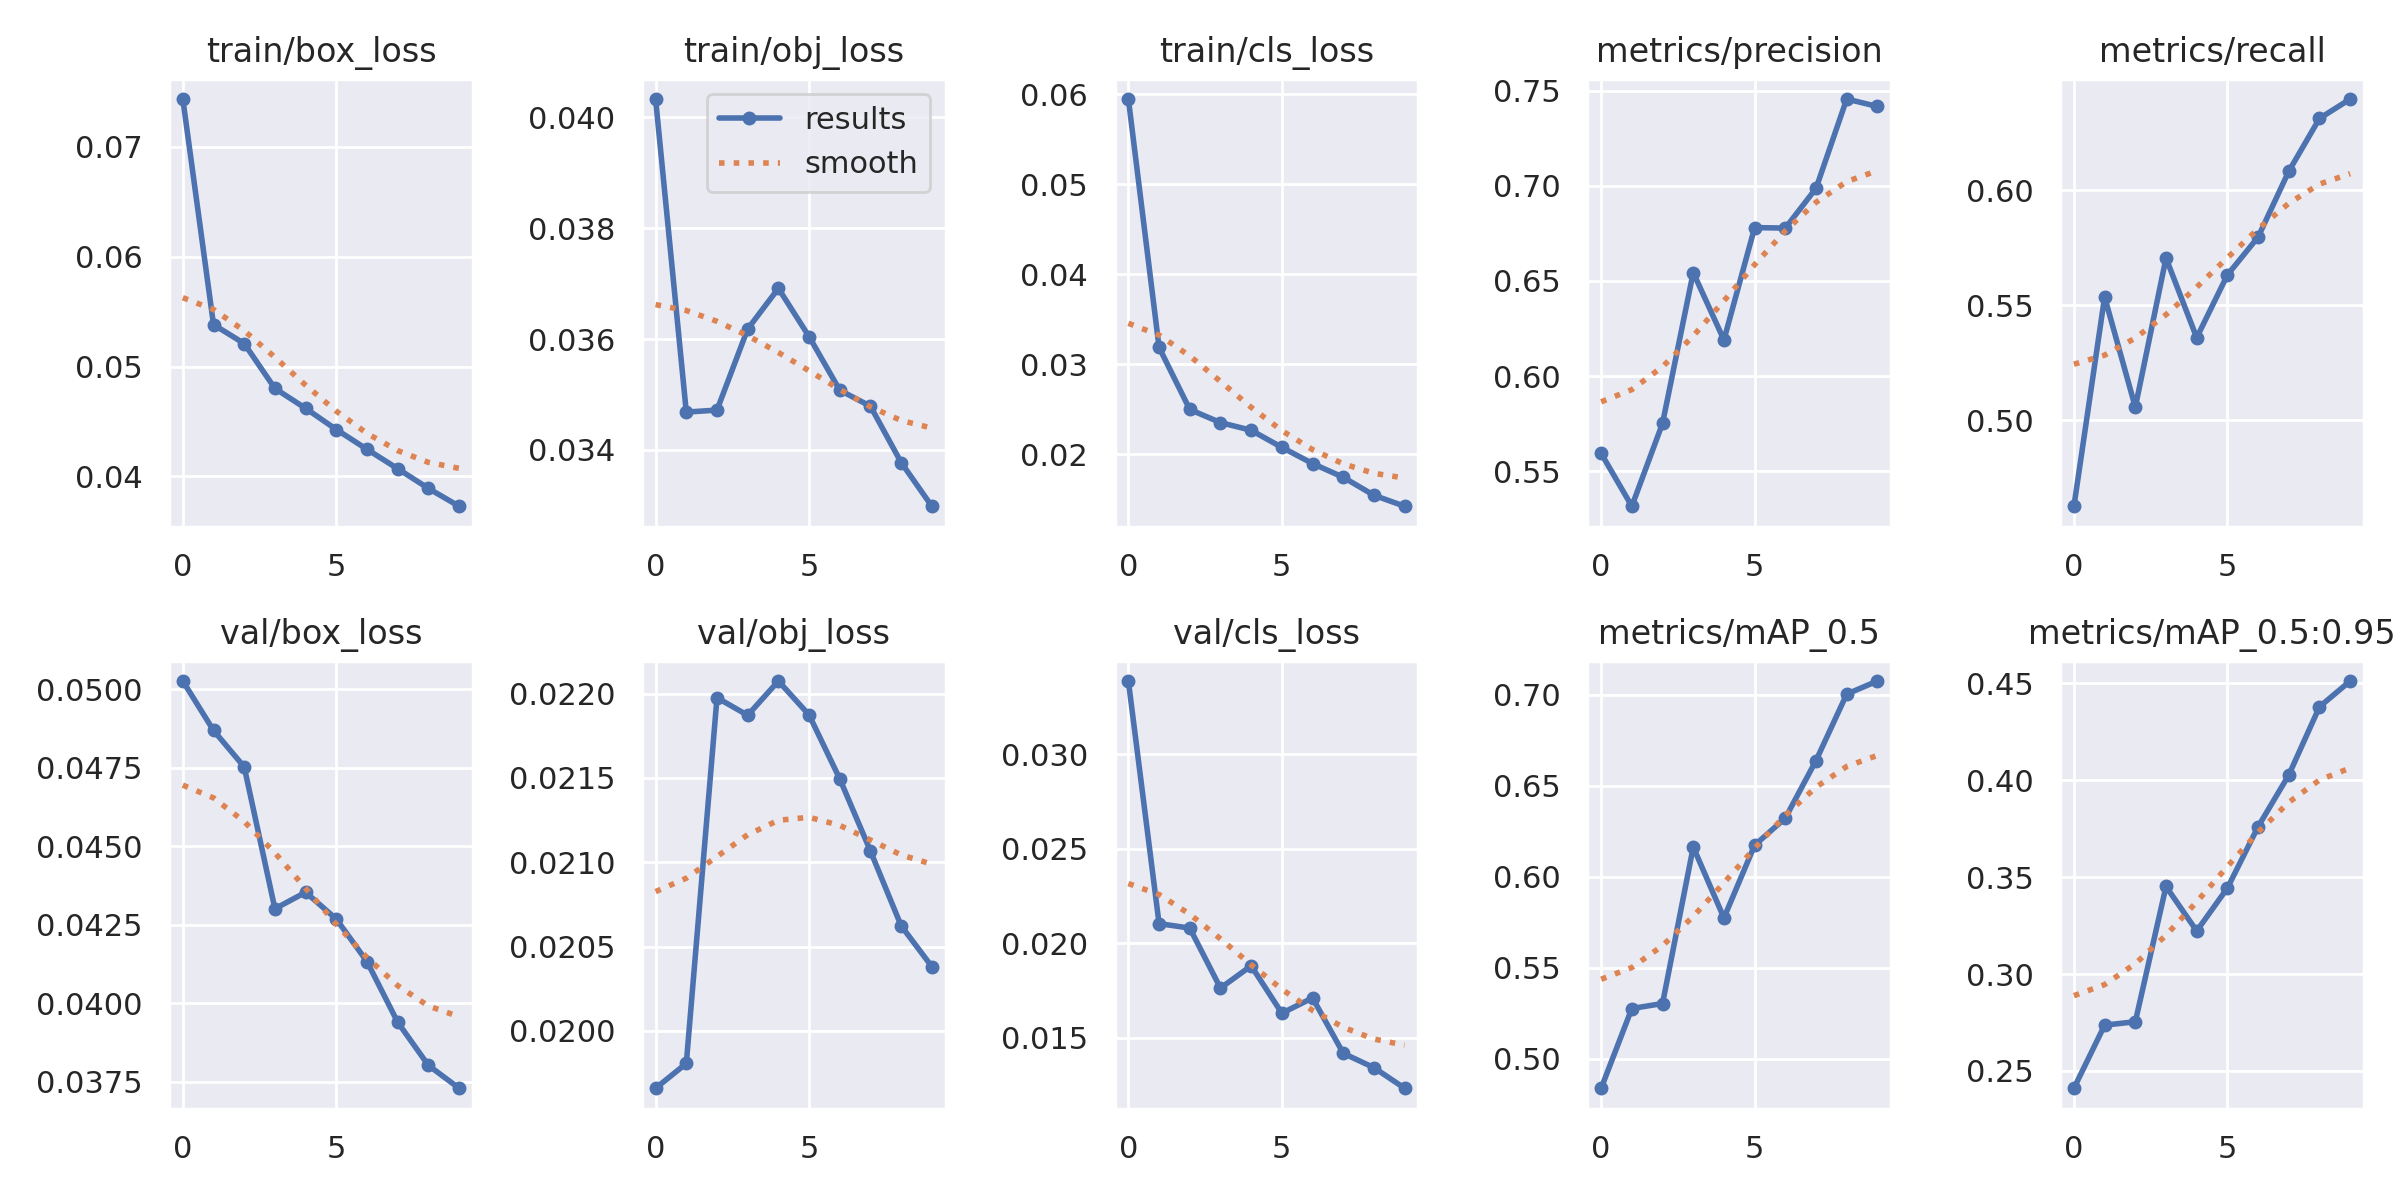


Confusion Matrix.Png:


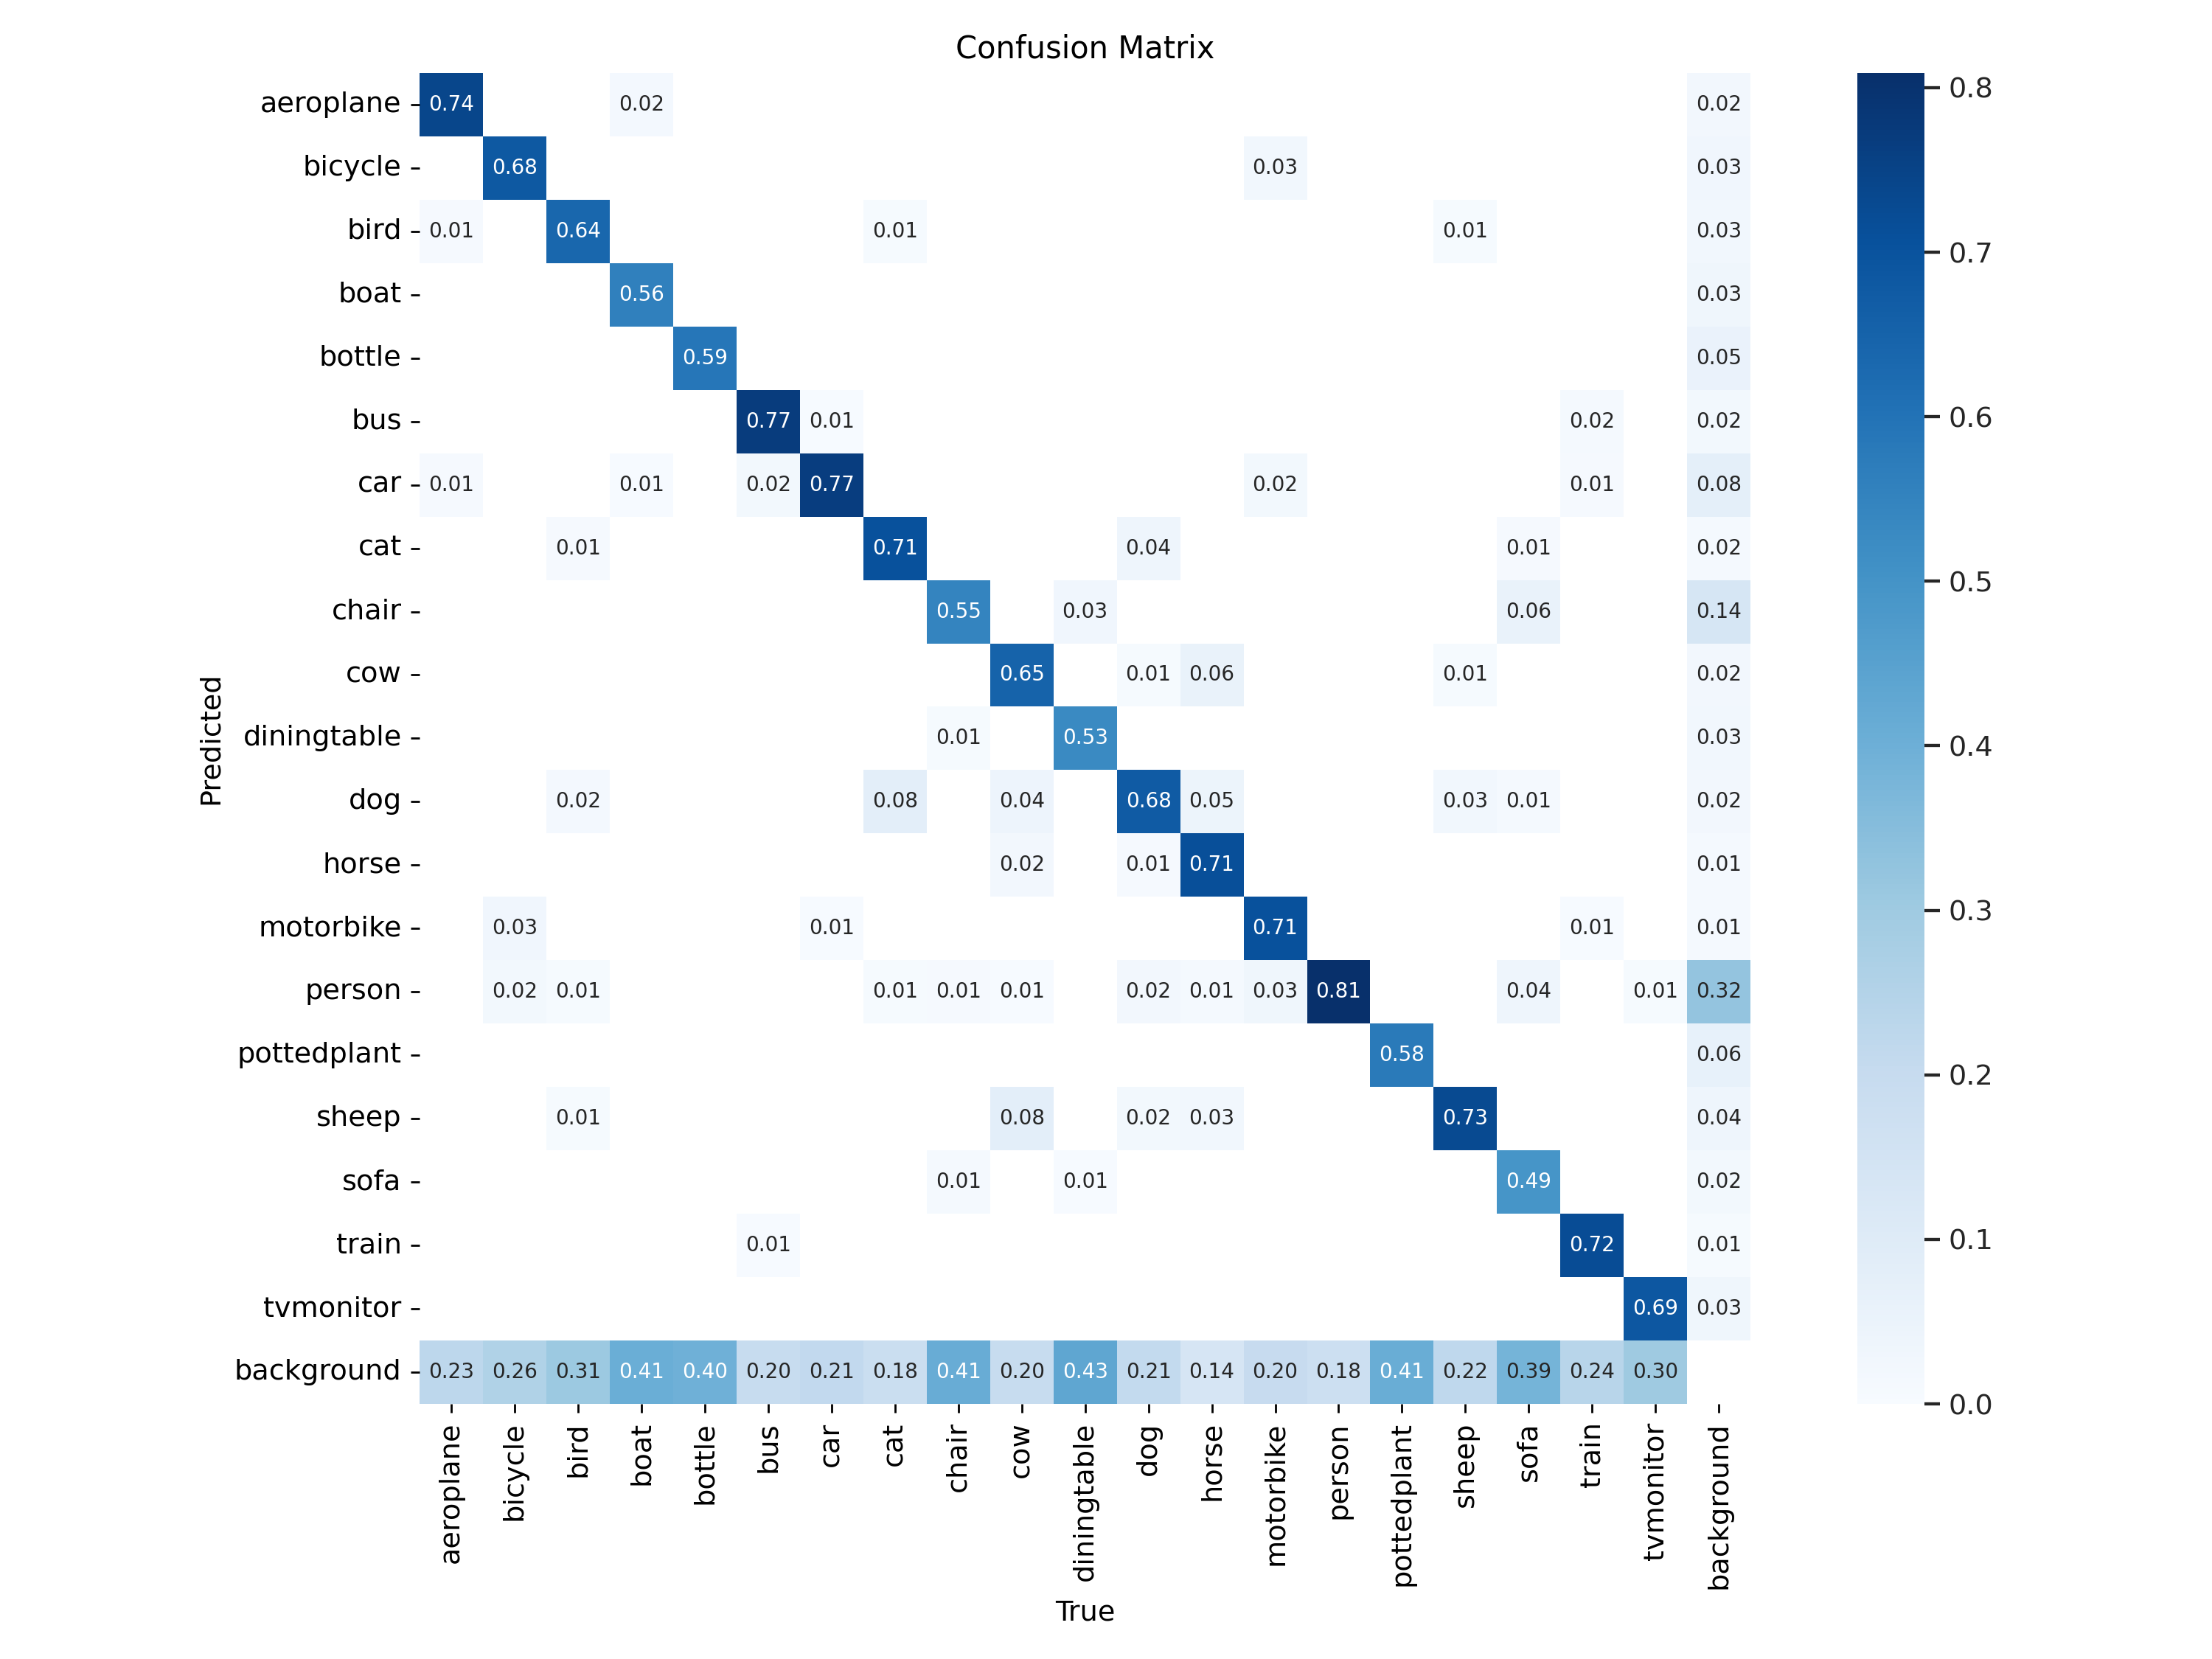


SAMPLE PREDICTIONS:

Validation Batch 0 Predictions:


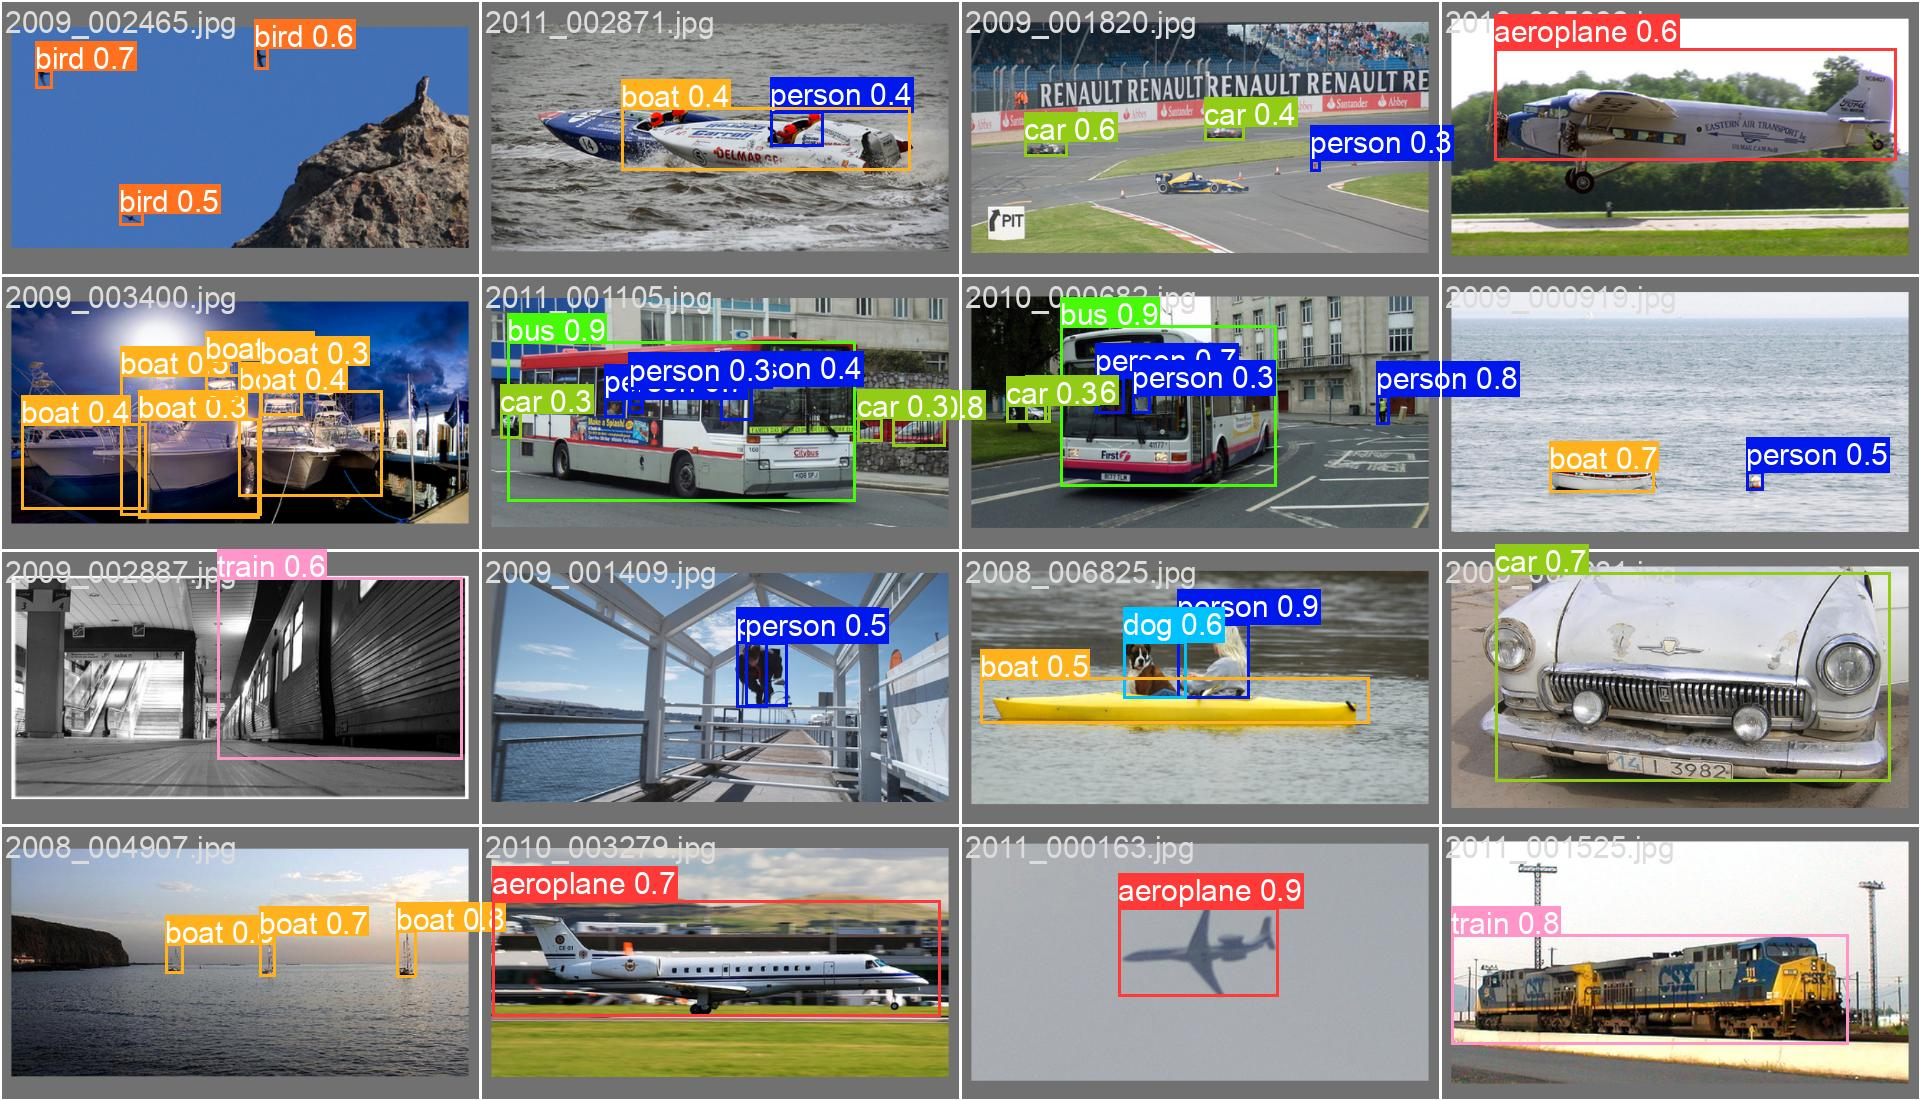


Validation Batch 1 Predictions:


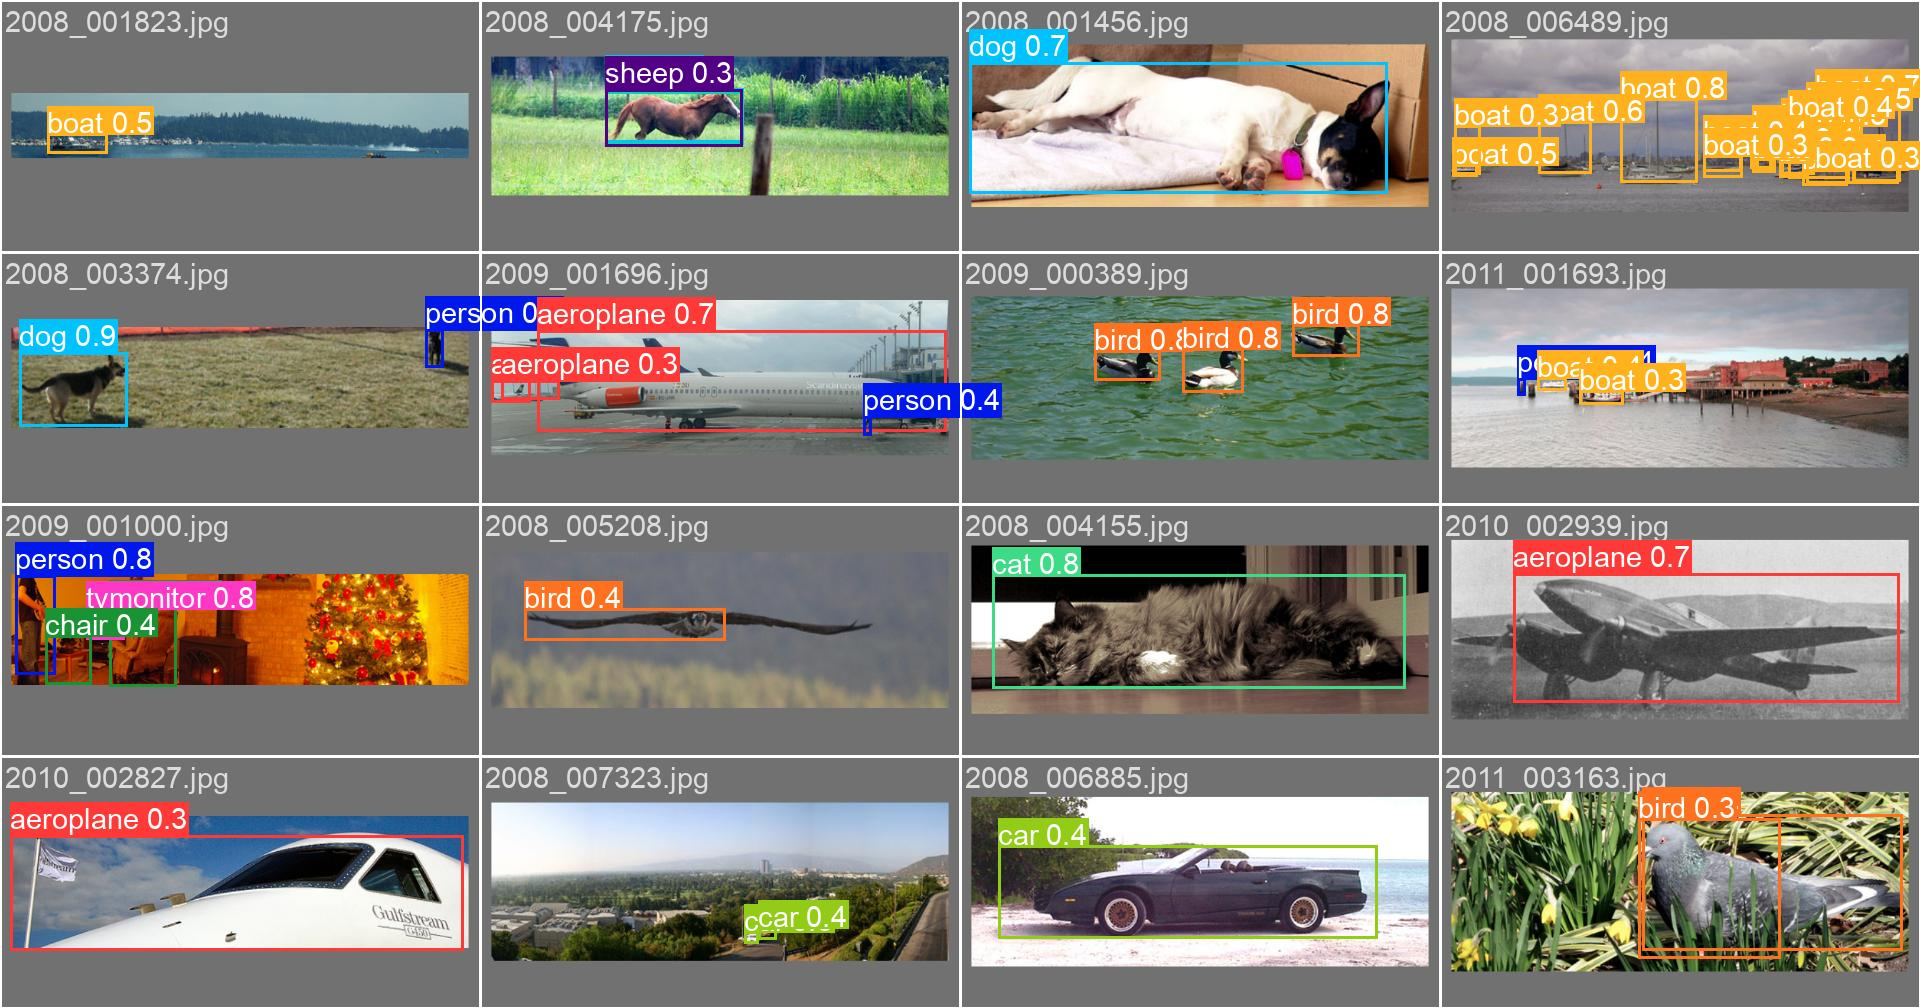


Validation Batch 2 Predictions:


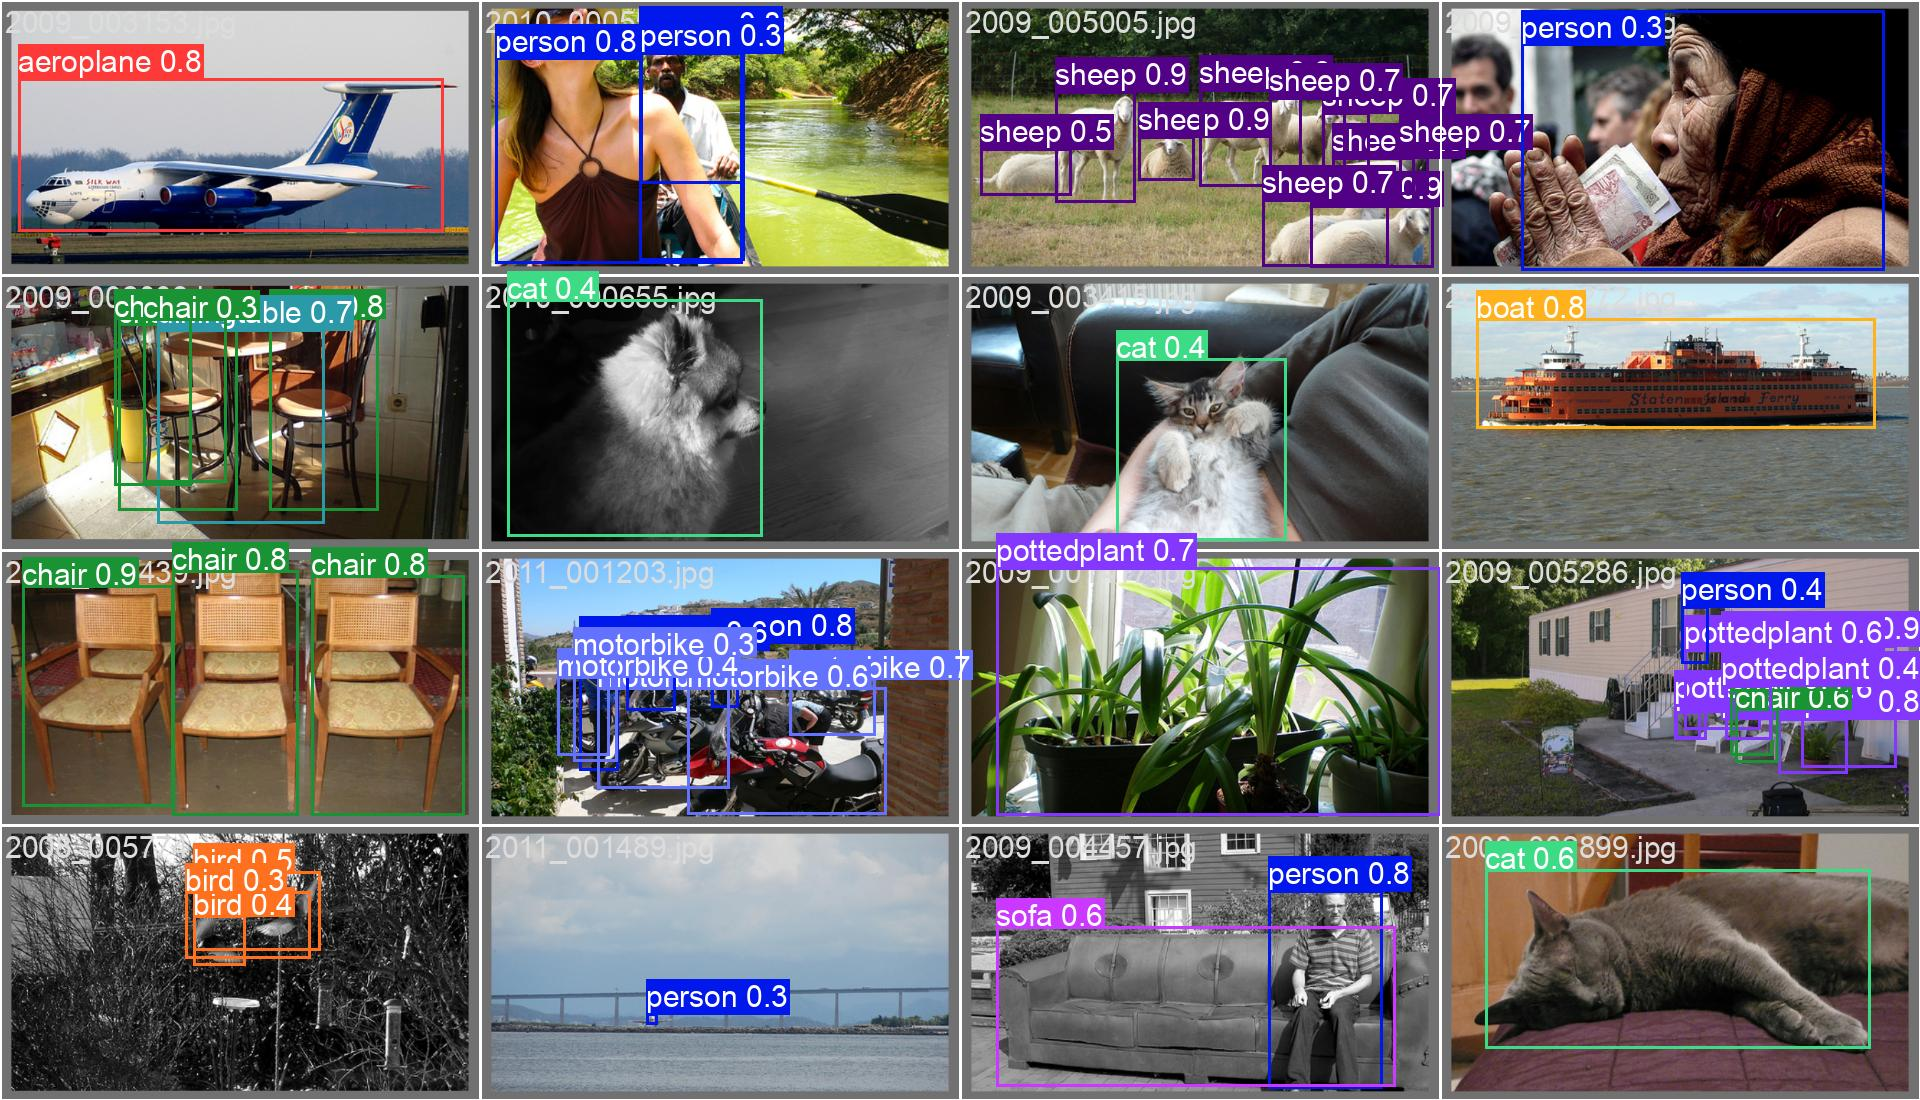

In [27]:
# Display Key Results and Visualizations
print("="*80)
print("YOLOv5 EXPERIMENT COMPLETED SUCCESSFULLY")
print("="*80)

if metrics and speed_results:
    # Extract and format values safely
    map_05 = f"{metrics['performance_metrics']['mAP_0.5']:.4f}" if 'performance_metrics' in metrics and 'mAP_0.5' in metrics['performance_metrics'] else 'N/A'
    map_05_095 = f"{metrics['performance_metrics']['mAP_0.5_0.95']:.4f}" if 'performance_metrics' in metrics and 'mAP_0.5_0.95' in metrics['performance_metrics'] else 'N/A'
    precision = f"{metrics['performance_metrics']['precision']:.4f}" if 'performance_metrics' in metrics and 'precision' in metrics['performance_metrics'] else 'N/A'
    recall = f"{metrics['performance_metrics']['recall']:.4f}" if 'performance_metrics' in metrics and 'recall' in metrics['performance_metrics'] else 'N/A'
    fps = f"{speed_results['fps']:.2f}" if 'fps' in speed_results else 'N/A'
    ms_per_image = f"{speed_results['ms_per_image']:.2f}" if 'ms_per_image' in speed_results else 'N/A'
    
    print(f"\nFINAL PERFORMANCE METRICS:")
    print(f"   mAP@0.5: {map_05}")
    print(f"   mAP@0.5:0.95: {map_05_095}")
    print(f"   Precision: {precision}")
    print(f"   Recall: {recall}")
    print(f"   Inference Speed: {fps} FPS")
    print(f"   Processing Time: {ms_per_image} ms/image")

print(f"\nOUTPUT FILES GENERATED:")
print(f"   Trained Model: {output_dir}/models/")
print(f"   Metrics & Analysis: {output_dir}/metrics/")
print(f"   Visualizations: {output_dir}/visualizations/")
print(f"   Comparison Results: {output_dir}/comparisons/")
print(f"   Final Report: {output_dir}/reports/")
print(f"   Training Logs: {output_dir}/logs/")

print(f"\nMODEL COMPARISON READY:")
print(f"   Standardized test images evaluated")
print(f"   Speed benchmarking completed")
print(f"   COCO metrics computed")
print(f"   Professional visualizations created")
print(f"   Comprehensive reports generated")

print(f"\nYOLOv5 pipeline ready for comparison with SSD300 and Faster R-CNN!")
print("="*80)

# Display some built-in YOLOv5 visualizations if available
viz_files = [
    'runs/train/yolov5s_voc_enhanced/results.png',
    'runs/train/yolov5s_voc_enhanced/confusion_matrix.png'
]

from IPython.display import Image as IPImage, display

print("\nTRAINING VISUALIZATIONS:")
for viz_file in viz_files:
    if os.path.exists(viz_file):
        print(f"\n{os.path.basename(viz_file).replace('_', ' ').title()}:")
        display(IPImage(viz_file))

# Show some sample predictions if available
pred_files = glob.glob('runs/train/yolov5s_voc_enhanced/val_batch*_pred.jpg')
if pred_files:
    print(f"\nSAMPLE PREDICTIONS:")
    for i, pred_file in enumerate(pred_files[:3]):  # Show first 3
        print(f"\nValidation Batch {i} Predictions:")
        display(IPImage(pred_file))

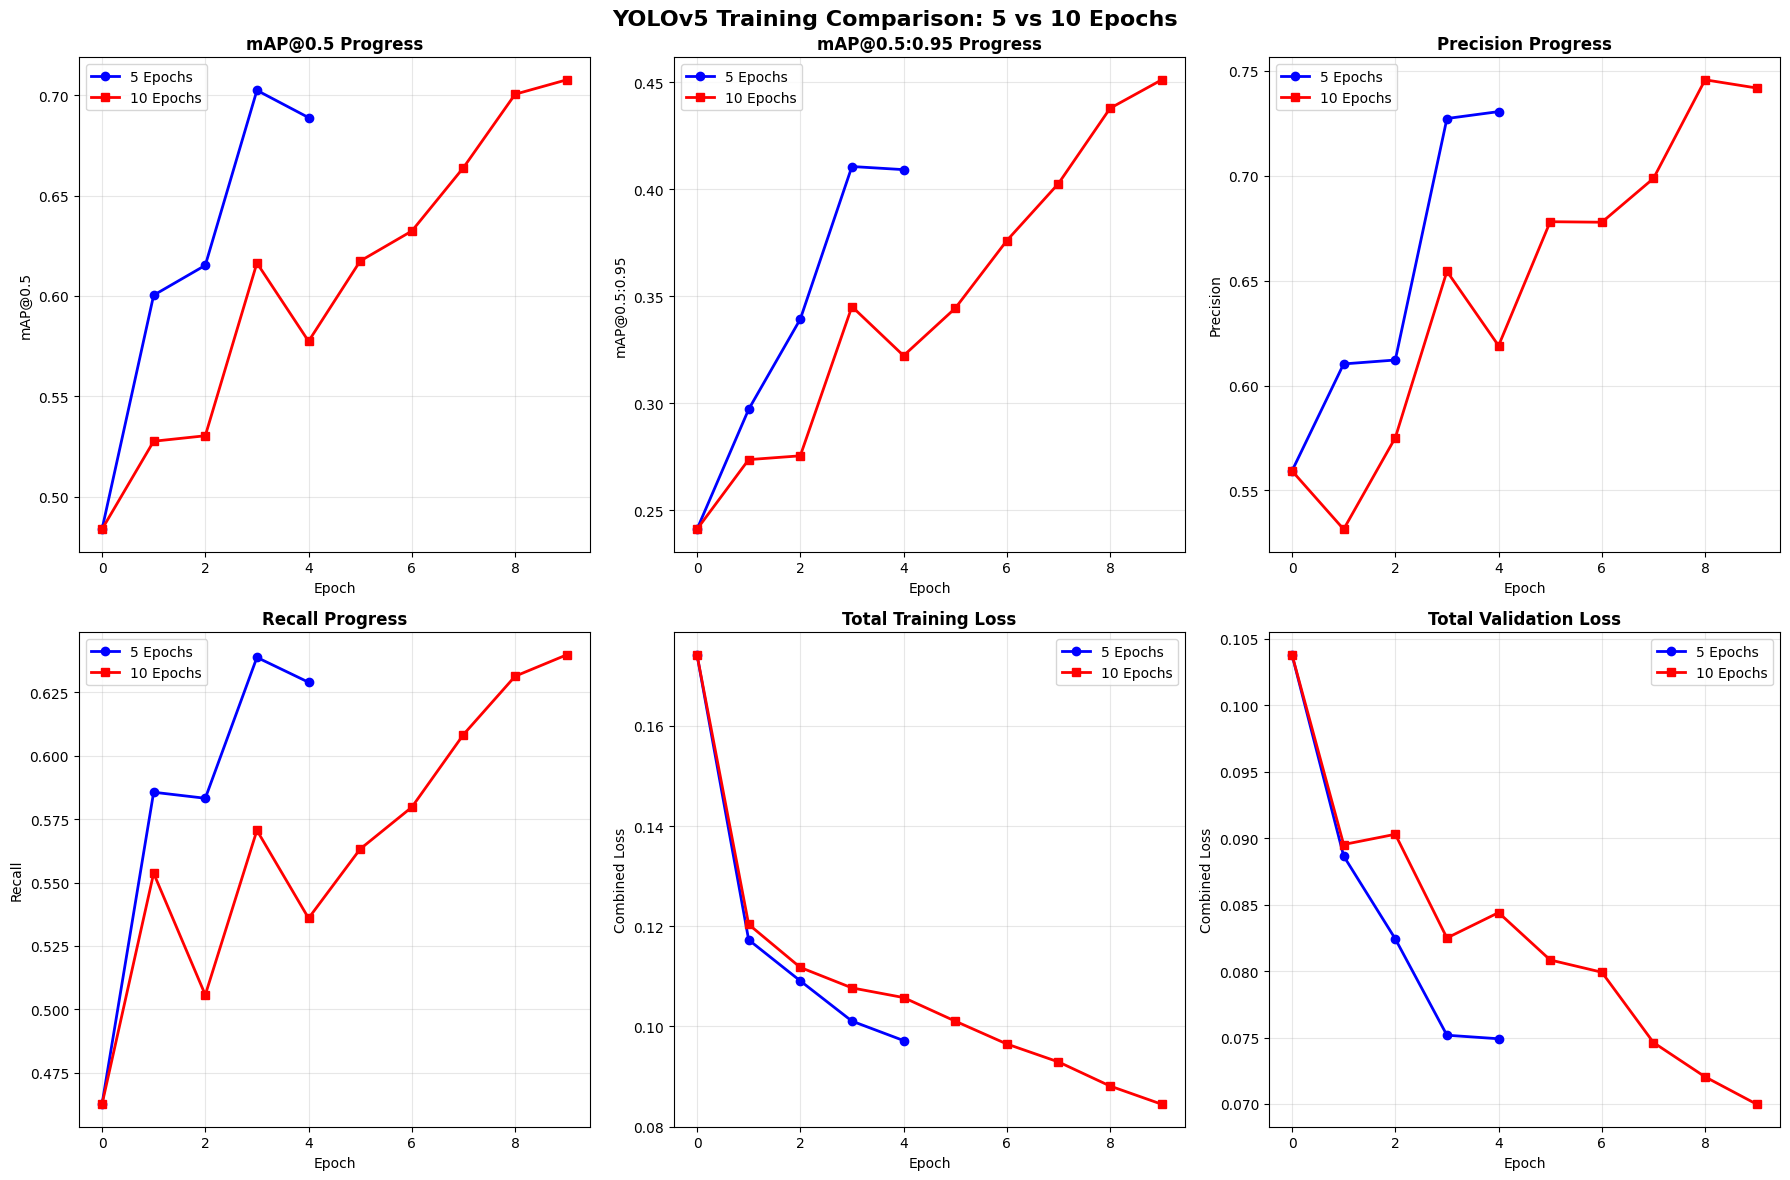

TRAINING COMPARISON: 5 EPOCHS vs 10 EPOCHS

FINAL RESULTS COMPARISON:
Metric               5 Epochs     10 Epochs    Improvement 
------------------------------------------------------------
mAP@0.5              0.6888       0.7077       +2.7%       
mAP@0.5:0.95         0.4091       0.4511       +10.3%      
Precision            0.7305       0.7417       +1.5%       
Recall               0.6289       0.6397       +1.7%       
Train Loss           0.0972       0.0845       -13.1%      
Val Loss             0.0749       0.0700       -6.6%       

KEY OBSERVATIONS:
1. mAP@0.5 improved from 0.689 to 0.708
2. mAP@0.5:0.95 improved from 0.409 to 0.451
3. Model continued learning beyond epoch 5
4. Training loss reduced further with additional epochs
5. Validation loss also continued to decrease

RECOMMENDATION:
Training for 10 epochs shows better performance. Consider this for final model.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data from your training runs
epochs_5_data = {
    'epoch': [0, 1, 2, 3, 4],
    'train_box_loss': [0.074355, 0.053304, 0.050239, 0.04503, 0.043526],
    'train_obj_loss': [0.04033, 0.034705, 0.034295, 0.034704, 0.034504],
    'train_cls_loss': [0.059491, 0.029283, 0.024569, 0.021342, 0.019167],
    'metrics_precision': [0.55932, 0.61028, 0.61214, 0.72717, 0.73046],
    'metrics_recall': [0.46264, 0.58557, 0.58319, 0.63869, 0.6289],
    'metrics_mAP_0.5': [0.48373, 0.60034, 0.61522, 0.70239, 0.68883],
    'metrics_mAP_0.5_0.95': [0.24109, 0.29711, 0.33926, 0.41057, 0.40911],
    'val_box_loss': [0.050261, 0.048201, 0.045716, 0.040726, 0.040146],
    'val_obj_loss': [0.01966, 0.019602, 0.019835, 0.019856, 0.020048],
    'val_cls_loss': [0.033882, 0.020857, 0.016874, 0.014593, 0.014715]
}

epochs_10_data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'train_box_loss': [0.074355, 0.053813, 0.052091, 0.048002, 0.046191, 0.044262, 0.042461, 0.040695, 0.038902, 0.037276],
    'train_obj_loss': [0.04033, 0.034683, 0.03472, 0.036182, 0.036915, 0.036045, 0.035078, 0.034789, 0.033774, 0.032985],
    'train_cls_loss': [0.059491, 0.031881, 0.02498, 0.023522, 0.022669, 0.020768, 0.018971, 0.017445, 0.015442, 0.014223],
    'metrics_precision': [0.55932, 0.53153, 0.57512, 0.6544, 0.61896, 0.67802, 0.67777, 0.69865, 0.74561, 0.7417],
    'metrics_recall': [0.46264, 0.55364, 0.50571, 0.57055, 0.53593, 0.56321, 0.57968, 0.6083, 0.63127, 0.63971],
    'metrics_mAP_0.5': [0.48373, 0.52758, 0.53031, 0.61638, 0.57739, 0.61737, 0.63231, 0.66392, 0.70047, 0.70765],
    'metrics_mAP_0.5_0.95': [0.24109, 0.27362, 0.2754, 0.34513, 0.32219, 0.34433, 0.37597, 0.40262, 0.4378, 0.45108],
    'val_box_loss': [0.050261, 0.048687, 0.047525, 0.043005, 0.04353, 0.042677, 0.041322, 0.03939, 0.038015, 0.037286],
    'val_obj_loss': [0.01966, 0.019807, 0.021975, 0.021871, 0.022074, 0.021873, 0.021494, 0.021066, 0.020623, 0.020381],
    'val_cls_loss': [0.033882, 0.021033, 0.020796, 0.017618, 0.018798, 0.016287, 0.017099, 0.014166, 0.013403, 0.012313]
}

def create_training_comparison():
    """Create comprehensive comparison between 5 and 10 epoch training"""
    
    # Create DataFrames
    df_5 = pd.DataFrame(epochs_5_data)
    df_10 = pd.DataFrame(epochs_10_data)
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('YOLOv5 Training Comparison: 5 vs 10 Epochs', fontsize=16, fontweight='bold')
    
    # Plot 1: mAP@0.5 comparison
    axes[0, 0].plot(df_5['epoch'], df_5['metrics_mAP_0.5'], 'b-o', label='5 Epochs', linewidth=2, markersize=6)
    axes[0, 0].plot(df_10['epoch'], df_10['metrics_mAP_0.5'], 'r-s', label='10 Epochs', linewidth=2, markersize=6)
    axes[0, 0].set_title('mAP@0.5 Progress', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('mAP@0.5')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: mAP@0.5:0.95 comparison
    axes[0, 1].plot(df_5['epoch'], df_5['metrics_mAP_0.5_0.95'], 'b-o', label='5 Epochs', linewidth=2, markersize=6)
    axes[0, 1].plot(df_10['epoch'], df_10['metrics_mAP_0.5_0.95'], 'r-s', label='10 Epochs', linewidth=2, markersize=6)
    axes[0, 1].set_title('mAP@0.5:0.95 Progress', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP@0.5:0.95')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Precision comparison
    axes[0, 2].plot(df_5['epoch'], df_5['metrics_precision'], 'b-o', label='5 Epochs', linewidth=2, markersize=6)
    axes[0, 2].plot(df_10['epoch'], df_10['metrics_precision'], 'r-s', label='10 Epochs', linewidth=2, markersize=6)
    axes[0, 2].set_title('Precision Progress', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Recall comparison
    axes[1, 0].plot(df_5['epoch'], df_5['metrics_recall'], 'b-o', label='5 Epochs', linewidth=2, markersize=6)
    axes[1, 0].plot(df_10['epoch'], df_10['metrics_recall'], 'r-s', label='10 Epochs', linewidth=2, markersize=6)
    axes[1, 0].set_title('Recall Progress', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Training Loss comparison (combined losses)
    train_loss_5 = np.array(df_5['train_box_loss']) + np.array(df_5['train_obj_loss']) + np.array(df_5['train_cls_loss'])
    train_loss_10 = np.array(df_10['train_box_loss']) + np.array(df_10['train_obj_loss']) + np.array(df_10['train_cls_loss'])
    
    axes[1, 1].plot(df_5['epoch'], train_loss_5, 'b-o', label='5 Epochs', linewidth=2, markersize=6)
    axes[1, 1].plot(df_10['epoch'], train_loss_10, 'r-s', label='10 Epochs', linewidth=2, markersize=6)
    axes[1, 1].set_title('Total Training Loss', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Combined Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Validation Loss comparison
    val_loss_5 = np.array(df_5['val_box_loss']) + np.array(df_5['val_obj_loss']) + np.array(df_5['val_cls_loss'])
    val_loss_10 = np.array(df_10['val_box_loss']) + np.array(df_10['val_obj_loss']) + np.array(df_10['val_cls_loss'])
    
    axes[1, 2].plot(df_5['epoch'], val_loss_5, 'b-o', label='5 Epochs', linewidth=2, markersize=6)
    axes[1, 2].plot(df_10['epoch'], val_loss_10, 'r-s', label='10 Epochs', linewidth=2, markersize=6)
    axes[1, 2].set_title('Total Validation Loss', fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Combined Loss')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("="*80)
    print("TRAINING COMPARISON: 5 EPOCHS vs 10 EPOCHS")
    print("="*80)
    
    print(f"\nFINAL RESULTS COMPARISON:")
    print(f"{'Metric':<20} {'5 Epochs':<12} {'10 Epochs':<12} {'Improvement':<12}")
    print("-" * 60)
    
    # Compare final values
    final_5 = {
        'mAP@0.5': df_5['metrics_mAP_0.5'].iloc[-1],
        'mAP@0.5:0.95': df_5['metrics_mAP_0.5_0.95'].iloc[-1],
        'Precision': df_5['metrics_precision'].iloc[-1],
        'Recall': df_5['metrics_recall'].iloc[-1],
        'Train Loss': train_loss_5[-1],
        'Val Loss': val_loss_5[-1]
    }
    
    final_10 = {
        'mAP@0.5': df_10['metrics_mAP_0.5'].iloc[-1],
        'mAP@0.5:0.95': df_10['metrics_mAP_0.5_0.95'].iloc[-1],
        'Precision': df_10['metrics_precision'].iloc[-1],
        'Recall': df_10['metrics_recall'].iloc[-1],
        'Train Loss': train_loss_10[-1],
        'Val Loss': val_loss_10[-1]
    }
    
    for metric in final_5.keys():
        val_5 = final_5[metric]
        val_10 = final_10[metric]
        
        if 'Loss' in metric:
            improvement = ((val_5 - val_10) / val_5) * 100  # For loss, reduction is improvement
            improvement_text = f"-{improvement:.1f}%"
        else:
            improvement = ((val_10 - val_5) / val_5) * 100  # For metrics, increase is improvement
            improvement_text = f"+{improvement:.1f}%"
        
        print(f"{metric:<20} {val_5:<12.4f} {val_10:<12.4f} {improvement_text:<12}")
    
    print(f"\nKEY OBSERVATIONS:")
    print(f"1. mAP@0.5 improved from {final_5['mAP@0.5']:.3f} to {final_10['mAP@0.5']:.3f}")
    print(f"2. mAP@0.5:0.95 improved from {final_5['mAP@0.5:0.95']:.3f} to {final_10['mAP@0.5:0.95']:.3f}")
    print(f"3. Model continued learning beyond epoch 5")
    print(f"4. Training loss reduced further with additional epochs")
    print(f"5. Validation loss also continued to decrease")
    
    print(f"\nRECOMMENDATION:")
    if final_10['mAP@0.5'] > final_5['mAP@0.5']:
        print("Training for 10 epochs shows better performance. Consider this for final model.")
    else:
        print("5 epochs might be sufficient, but 10 epochs shows more stable training.")

# Run the comparison
create_training_comparison()

In [1]:
import shutil; shutil.make_archive('/kaggle/working/yolov5_runs_download', 'zip', '/kaggle/working/yolov5/runs')

'/kaggle/working/yolov5_runs_download.zip'